# Without Group Theory

In [ ]:
%load_ext line_profiler
%load_ext autoreload
# provide cell timings
%load_ext autotime
%autoreload 2
import sympy as sp
import numpy as np
%config InlineBackend.figure_format='retina'
%config Completer.use_jedi = False
from qdef import *
from misc import *
from IPython.display import display, Math, Latex, HTML
from itertools import product, permutations
plt.style.use('dark_background')

Group theory offers the means to block diagonalize the hamiltonian into blocks that correspond to multi-electron terms. However, this multi-electron basis is not necessary to compute the eigenvalues or eigenvectors of the Hamiltonian.

Here is the development code for the function `qdef.hamiltonian_CF_CR` which provides a sympy symbolic expression that represents the Hamiltonian for the ground state as influenced by a crystal field of a given symmetry and as influenced by the Coulomb repulsion between a number of valence electrons.

As an example of use, the Tanabe-Sugano diagrams for a number of ions are reproduced.

In [10]:
γexps = {2: 4.42, 3: 4.50, 4: 4.61, 5: 4.48, 6: 4.81, 7: 4.63, 8: 4.71}
Bexps =  {2: 860, 3:918 , 4:965 , 5:860, 6: 1065, 7: 971, 8:1030}
atoms = dict(zip([2,3,4,5,6,7,8], 'V,3 Cr,3 Mn,3 Mn,2 Co,3 Co,2 Ni,2'.split(' ')))
Dqs = np.linspace(0,4,80)
ymax = 75

subs = {sp.Symbol('F_{(4)}') : sp.Symbol('F^{(4)}')/441,
        sp.Symbol('F_{(0)}'): sp.Symbol('F^{(0)}'),
        sp.Symbol('F_{(2)}'): sp.Symbol('F^{(2)}')/49}
A = sp.Symbol('F_{(0)}') - 49 * sp.Symbol('F_{(4)}')
A = A.subs(subs)
B = sp.Symbol('F_{(2)}') - 5 * sp.Symbol('F_{(4)}')
B = B.subs(subs)
C = 35*sp.Symbol('F_{(4)}')
C = C.subs(subs)
slater_to_Racah = sp.solve([sp.Symbol('A') - A, 
                        sp.Symbol('B') - B,
                        sp.Symbol('C') - C],
                        (sp.Symbol('F^{(0)}'), sp.Symbol('F^{(2)}'), sp.Symbol('F^{(4)}')))

Reloading /Users/juan/Zia Lab/Codebase/qdef/data/CPGs.pkl ...


N=2
Using spherical harmonics basis.


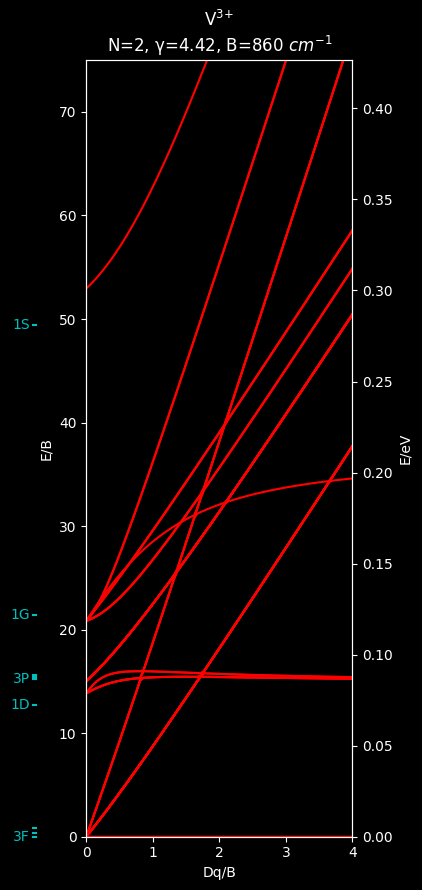

N=3
Using spherical harmonics basis.


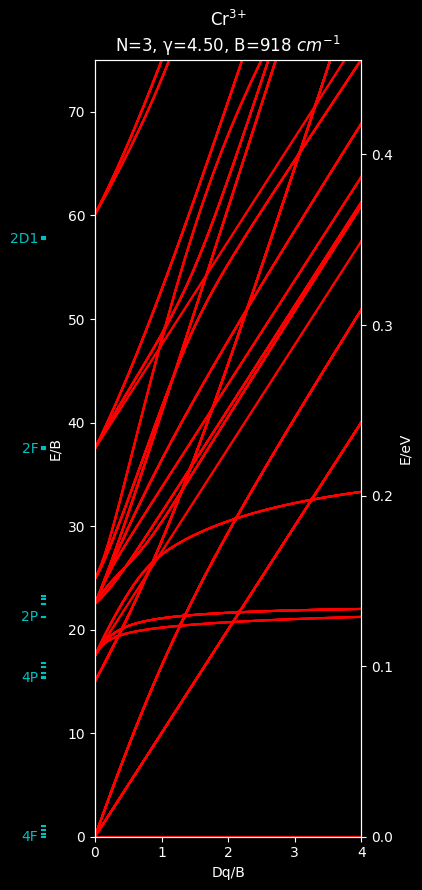

N=4
Using spherical harmonics basis.


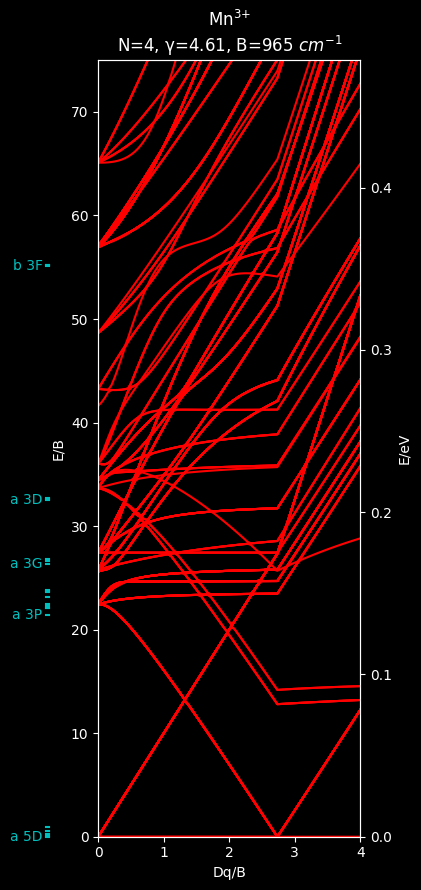

N=5
Using spherical harmonics basis.


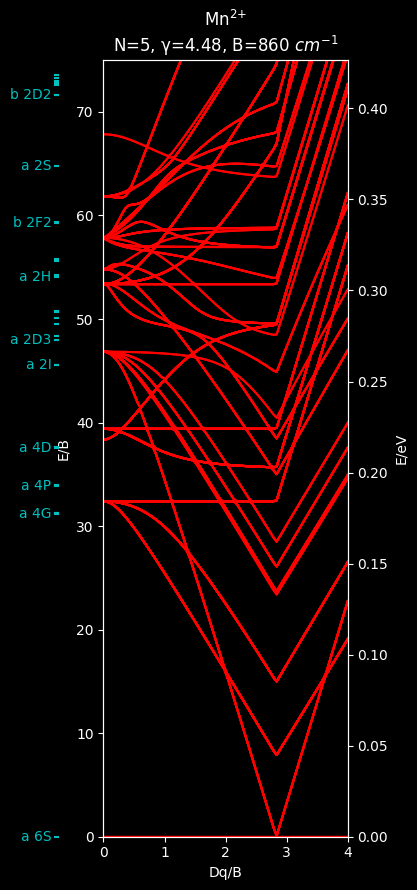

N=6
Using spherical harmonics basis.


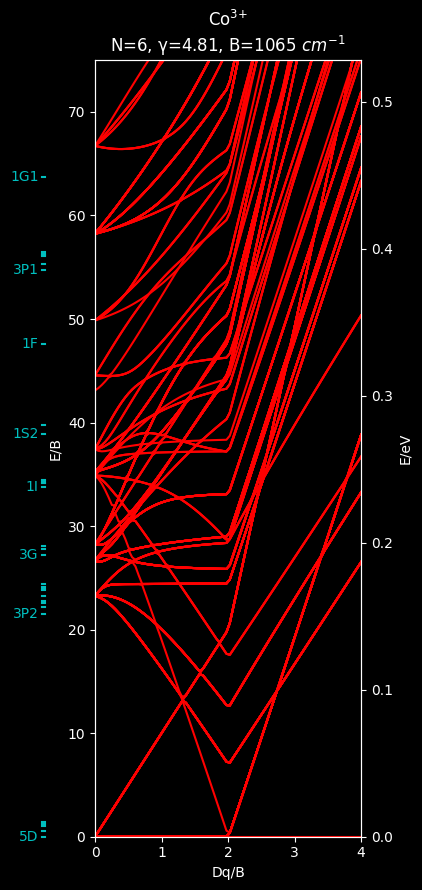

N=7
Using spherical harmonics basis.


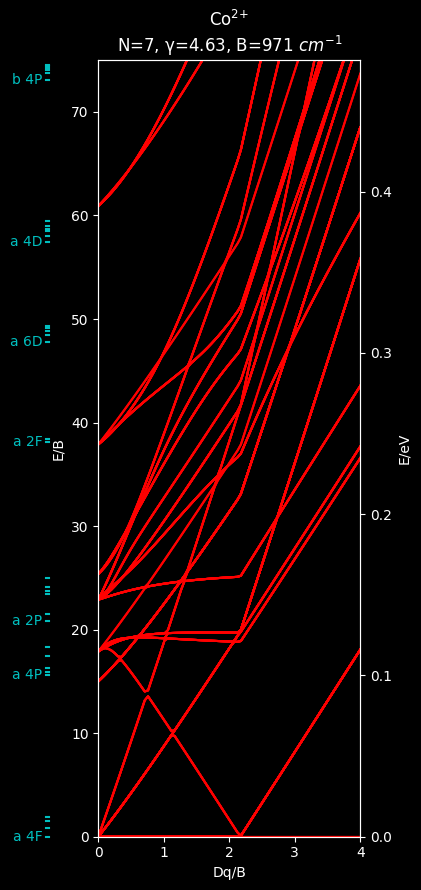

N=8
Using spherical harmonics basis.


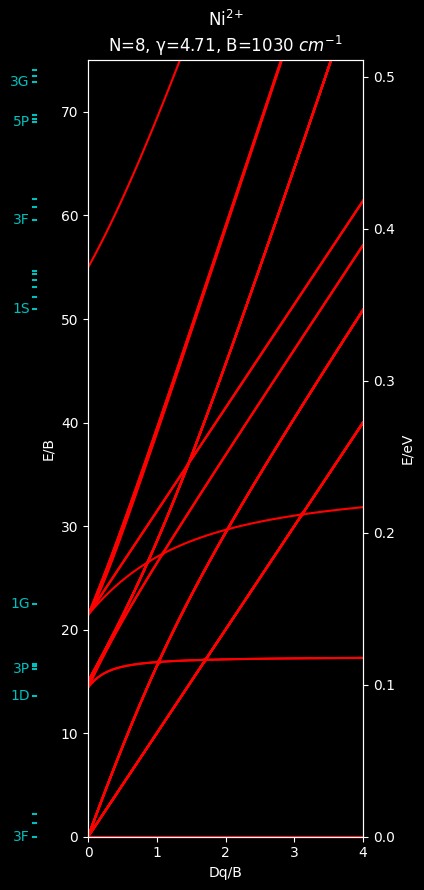

In [11]:
sparse = True
Dqs = np.linspace(0,4,80)
ymax = 75

for num_electrons in [2,3,4,5,6,7,8]:
    print('N=%d' % num_electrons)
    atom = atoms[num_electrons].split(',')[0]
    charge_state =  int(atoms[num_electrons].split(',')[1])
    γexp = γexps[num_electrons]
    ion = Ion(atom, charge_state)
    Bexp = Bexps[num_electrons]

    hamiltonian = hamiltonian_CF_CR(num_electrons, 'O', 2, sparse, True)[0]
    hamiltonian = hamiltonian.subs(slater_to_Racah)
    # A just changes everything by a constant amount
    # B is set to 1 to set it as the unit of energy
    # C is set to gamma, which would be C in units of B
    # B_{4,0} is set to 21*Dq to match standard notation
    hamiltonian = hamiltonian.subs({sp.Symbol('A'): 0, 
                  sp.Symbol('B_{4,0}'): 21*sp.Symbol('Dq'),
                  sp.Symbol('B'): 1,
                  sp.Symbol('C'): sp.Symbol('\\gamma_{CB}')})
    hamlambda = sp.lambdify((sp.Symbol('\\gamma_{CB}'), sp.Symbol('Dq')), hamiltonian)

    all_energies = []
    for Dq in Dqs:
        energies = np.real(np.linalg.eigvals(hamlambda(γexp, Dq).todense()))
        energies = np.sort(energies - np.min(energies))
        all_energies.append(energies)
    all_energies = np.array(all_energies).T

    exp_levels = ion.nist_data['Level (eV)'] * UnitCon.con_factor('eV','cm^{-1}') / Bexp
    term_labels =  ion.nist_data['Term']
    selector = exp_levels < ymax
    exp_levels = exp_levels[selector]
    term_labels = term_labels[selector]

    fig, ax = plt.subplots(figsize=(3*1.5,6*1.5))

    for row in all_energies:
        plt.plot(Dqs,row,'r')
    y_str = []
    first = True
    for exp_level, term_label in zip(exp_levels, term_labels):
        line = plt.Line2D([-0.8,-0.75],[exp_level]*2,c='c')
        line.set_clip_on(False)
        ax.add_line(line)
        if (len(y_str)>0 and min(([abs(ys - exp_level) for ys in y_str])) > 2) or first:
            plt.text(-.85,exp_level,term_label,ha='right', va='center', c='c')
            first = False
        y_str.append(exp_level)
    plt.xlim(0,Dqs[-1])
    plt.ylim(0,ymax)
    plt.xlabel('Dq/B')
    plt.ylabel('E/B')
    axright = ax.twinx()  # instantiate a second axes that shares the same x-axis
    axright.set_ylim(0, Dqs[-1]*Bexp*UnitCon.con_factor('cm^{-1}','eV'))
    axright.set_ylabel('E/eV')
    plt.title('%s${}^{%d\!+}$\nN=%d, γ=%.2f, B=%.0f $cm^{-1}$' % (atom, charge_state, num_electrons, γexp, Bexp))
    plt.tight_layout()
    # plt.savefig('TSK-%d.pdf' % num_electrons)
    plt.show()

# !!!!DEVELOPMENT FROM HERE TILL END!!!!!

# Functions & Constants

In [2]:
# subs = {sp.Symbol('F_{(4)}') : sp.Symbol('F^{(4)}')/441,
#         sp.Symbol('F_{(0)}'): sp.Symbol('F^{(0)}'),
#         sp.Symbol('F_{(2)}'): sp.Symbol('F^{(2)}')/49}
# A = sp.Symbol('F_{(0)}') - 49 * sp.Symbol('F_{(4)}')
# A = A.subs(subs)
# B = sp.Symbol('F_{(2)}') - 5 * sp.Symbol('F_{(4)}')
# B = B.subs(subs)
# C = 35*sp.Symbol('F_{(4)}')
# C = C.subs(subs)
# slater_to_Racah = sp.solve([sp.Symbol('A') - A, 
#                         sp.Symbol('B') - B,
#                         sp.Symbol('C') - C],
#                         (sp.Symbol('F^{(0)}'), sp.Symbol('F^{(2)}'), sp.Symbol('F^{(4)}')))

In [112]:
def determine_irrep(component):
    matches = [ir for ir, comps in component_labels.items() if component in comps]
    if len(matches) == 1:
        return matches[0]
    else:
        raise Exception("Invalid component")

def a_simplifier(qnums, coeff):
    l1, m1, l2, m2 = qnums
    if m1 == m2:
        return {(1,): coeff}
    else:
        return {}

def another_simplifier(qnums, coeff):
    γ1, γ2  = qnums
    if γ1 == γ2:
        the_irrep = determine_irrep(γ1)
        if the_irrep == sp.Symbol('E'):
            return {sp.Symbol('B_{4,0}'): coeff*sp.S(2)/7}
        elif the_irrep == sp.Symbol('T_2'):
            return {sp.Symbol('B_{4,0}'): (-1)*coeff*sp.S(4)/21}
        else:
            1/0
    else:
        return {}

def another_simplifier(qnums, coeff):
    γ1, γ2  = qnums
    if γ1 == γ2:
        the_irrep = determine_irrep(γ1)
        if the_irrep == sp.Symbol('E'):
            return {sp.Symbol('B_{4,0}'): coeff*sp.S(2)/7}
        elif the_irrep == sp.Symbol('T_2'):
            return {sp.Symbol('B_{4,0}'): (-1)*coeff*sp.S(4)/21}
        else:
            1/0
    else:
        return {}

def two_braket_basis_change(braket, basis_changer):
    '''
    Take  a  qet,  understood  as  a  TWO  symbol braket, and a
    dictionary  that  maps  the  current basis to a new one, and
    return  the resulting expression for the new braket in terms
    of  the new basis. All throughout it is assumed that between
    the given braket there is an implicit operator.

    Parameters
    ----------
    braket   (qdefcore.Qet)
    basis_changer (dict):  keys being  equal  to single electron
    quantum  symbols  and  values  to  qets  that  determine the
    superposition of the new basis to which this vector is being
    mapped to. The keys of the dictionary need not  include  all
    the quantum symbols included in the qet.

    Returns
    -------
    new_braket (qdefcore.Qet)

    Example
    -------

    braket = Qet({(1,2,3,4): 5,
                (8,4,3,1): 1})
    basis_change = {1: Qet({(8,): sp.I})}
    print(braket_basis_change(braket, basis_change))
    >> {(8, 2, 3, 4): -5*I, (8, 4, 3, 8): I}

    '''

    new_braket = Qet({})
    for k, v in braket.dict.items():
        βi, βj = [(Qet({(γ,):1}) if γ not in basis_changer else basis_changer[γ]) for γ in k]
        βi = βi.dual()
        γiγj = (βi * βj)
        new_braket = new_braket + (v*γiγj)
    return new_braket

import networkx as nx
def block_form(matrix):
    '''
    This  function  takes  a matrix and rearranges its columns and rows so
    that  it  is  in  block  diagonal form. It returns a tuple whose first
    element is the reorganized matrix, whose second element is the are the
    blocks  themselves, whose third element is the reordering of the rows,
    and whose fourth element is the reordering of the columns.

    As of now, it is a little ad-hoc and may fail horribly.

    If this has a solution, there's many of them, this function would give
    one of those.

    Example
    -------

    >>> test_matrix = sp.Matrix(sp.BlockDiagMatrix(*[sp.randMatrix(s) for s in [3,1,2]]))
    >>> size = test_matrix.rows
    >>> num_shuffles = 20
    >>> for _ in range(num_shuffles):
    >>>     direction = randint(0,1)
    >>>     col1 = randint(0,size-1)
    >>>     col2 = randint(0,size-1)
    >>>     permutation = list(range(size))
    >>>     permutation[col1], permutation[col2] = col2, col1
    >>>     test_matrix = test_matrix.permute(permutation,orientation=['cols','rows'][direction])
    >>> display(test_matrix)
    >>> display(block_form(test_matrix)[0])


    '''
    matrix = sp.Matrix(matrix)
    connectome = []
    # when this is called, sympy lets go of the elements that are zero
    nonz = list(matrix.todok().keys())
    for node in nonz:
        connectome.extend([(node, k) for k in nonz if
                           ((k[0] == node[0] or k[1] == node[1]))])
    matrixdok = matrix.todok()
    matrixGraph = nx.Graph()
    matrixGraph.add_edges_from(connectome)
    # reorganize columns and rows into block - diagonal form
    components = list(nx.connected_components(matrixGraph))
    components.sort(key=len)
    size = matrix.rows
    blocks = []
    index_maps_h = {}
    index_maps_v = {}
    block_stride = 0
    for component in components:
        component = list(component)
        indices_0 = sorted(list(set([x[0] for x in component])))
        indices_1 = sorted(list(set([x[1] for x in component])))
        block_size = len(indices_0)
        mapping_v = {i0: k for k, i0 in zip(range(block_size), indices_0)}
        mapping_h = {i1: k for k, i1 in zip(range(block_size), indices_1)}
        index_maps_v.update({(k+block_stride): i0 for
                             k, i0 in zip(range(block_size), indices_0)})
        index_maps_h.update({(k+block_stride): i1 for
                             k, i1 in zip(range(block_size), indices_1)})
        block = {(mapping_v[c[0]], mapping_h[c[1]])
                  : matrixdok[(c[0], c[1])] for c in component}
        blocks.append(sp.SparseMatrix(block_size, block_size, block))
        block_stride += block_size
    # calculate the permutted bases
    col_reordering = [index_maps_h[k] for k in range(size)]
    row_reordering = [index_maps_v[k] for k in range(size)]
    return sp.Matrix(sp.BlockDiagMatrix(*blocks)), blocks, col_reordering, row_reordering

In [4]:
def simpler_two_electron_braket(qet0, qet1):
    qet0 = qet0.dual()
    qet01 = qet0*qet1
    braket = Qet({})
    for k,v in qet01.dict.items():
        γ1, γ2, γ3, γ4 = k
        spin_up1 = 'bar' not in str(γ1)
        spin_up2 = 'bar' not in str(γ2)
        spin_up3 = 'bar' not in str(γ3)
        spin_up4 = 'bar' not in str(γ4)
        if spin_up1 == spin_up3 and spin_up2 == spin_up4:
            braket = braket + Qet({(γ1, γ2, γ3, γ4):v})
        elif spin_up1 == spin_up4 and spin_up2 == spin_up3:
            braket = braket + Qet({(γ1, γ2, γ4, γ3):-v})
    return strip_spin(braket)

In [3]:
def hamiltonian_CF_CR(num_electrons, group_label, l, sparse=False, force_standard_basis=False):
    '''
    Given  a  crystal field on an an ion with a given number of electrons,
    this  function  provides  the  matrix that represents the hamiltionian
    that includes the crystal field together with the Coulomb repulsion.

    This  Hamiltonian only describes how the ground state is split both by
    the  crystal  field  and by the Coulomb repulsion. The contribution to
    the  total  energy,  as  provided  by the interaction with the nuclear
    charge  does  not  figure  here, because it merely provides a constant
    shift to all the energy levels included in this description.

    In  all  cases  the  basis  used  in this matrix representation of the
    Hamiltonian  is  composed  of  slater  determinants of single-electron
    states.  If  force_standard_basis=True  then the angular part of these
    states    is    given    by    standard    spherical    harmonic    if
    force_standard_basis=False  then  the single-electron states are taken
    as  the  eigenvectors of the single-electron crystal field. In forming
    these slater determinants spin=1/2 is assumed.

    The  Coulomb  repulsion appears as Slater integrals of several orders,
    and  the  crystal  field  contribution as a function of the parameters
    that parametrize it according to the corresponding symmetry group.

    If  the crystal field for a single electron is possible to diagonalize
    symbolically, then the basis used for the hamiltonian is an eigenbasis
    for  it, if not, then the single-electron basis is simply the full set
    of spherical harmonics for the given value of l  (multiplied by radial
    parts that figure as the parameters of the model hamiltonian).

    Parameters
    ----------

    num_electrons (int): how many electrons are there included.

    group_label   (str): label for one of the 32

    l             (int): angular momentum of pressumed ground state

    sparse (Bool): if True then the returned matrix is sp.SparseMatrix

    force_standard_basis  (Bool):  whether  to  force  use of the standard
    spherical  harmonic basis, instead of allowing for the eigenvectors of
    the crystal field to be used.

    Returns
    ------

    hamiltonian  (sp.SparseMatrix): in terms of Slater integrals F^{k} (or
    Racah  parameters  if  to_Racah  is  provided)  and  the crystal field
    parameters adequate to the group.

    basis_change  (OrderedDict): the keys being the labels used internally
    for   calculations   and   the   values   being   Qets  understood  as
    superpositions of spherical harmonics. This for  the  single  electron
    states which are used to create multi-electron states.

    slater_dets  (list):  a  list  of  symbols  that represents the slater
    determinants  used for the basis in which the hamiltonian is computed,
    in  here  a  symbol with a bar on top is understood to have spin down,
    and  one  without  to have spin up (m=1/2). Together with basis_change
    this could be used to generate the multi-electron determinantal states
    in terms of slater determinants of spherical harmonics.

    '''
    uID = (num_electrons, group_label, l, sparse, force_standard_basis)

    if uID in hamiltonian_CF_CR.matrices:
        return hamiltonian_CF_CR.matrices[uID]

    group_index = CPGs.all_group_labels.index(group_label) + 1

    cf_field = crystal_splits[group_index]
    crystal_basis = (len(cf_field['eigen_system']) > 0)
    
    if crystal_basis:
        eigen_sys = cf_field['eigen_system'][0]

    if crystal_basis and not force_standard_basis:
        print("Using crystal field basis.")
        basis_change = OrderedDict()
        eigen_counter = 0
        basis_energies = {}
        for eigen_part in eigen_sys:
            eigen_energy = eigen_part[0]
            for eigen_vec in eigen_part[2]:
                eigen_label = sp.Symbol('\\alpha_{%d}' % (eigen_counter))
                spherical_combo = Qet({(l,m): n for m,n in zip(range(-l,l+1),list(eigen_vec.T)) if n!= 0})
                normalizer = sp.S(1)/spherical_combo.norm()
                basis_change[eigen_label] = normalizer*spherical_combo
                basis_energies[eigen_label] = eigen_energy
                eigen_counter += 1
        single_e_basis = list(basis_change.keys())
        def simple_energy(qnums, coeff):
            the_dict = {1:0}
            γ1, γ2 = qnums
            if γ1 == γ2:
                the_dict[1] = coeff*basis_energies[γ1]
            if the_dict[1] == 0:
                return {}
            return the_dict
    else:
        print("Using spherical harmonic basis.")
        single_e_basis = [sp.Symbol('Y_{%d,%d}' % (l,m)) for m in range(-l,l+1)]
        basis_change = OrderedDict([(sp.Symbol('Y_{%d,%d}' % (l,m)),Qet({(l,m):1})) for m in range(-l,l+1)])
        ham = cf_field['matrices'][0]
        def simple_energy(qnums, coeff):
            the_dict = {1:0}
            γ1, γ2 = qnums
            γ1idx = single_e_basis.index(γ1)
            γ2idx = single_e_basis.index(γ2)
            the_dict[1] = coeff*ham[γ1idx,γ2idx]
            if the_dict[1] == 0:
                return {}
            else:
                return the_dict

    # add spin up and spin down
    single_e_spin_orbitals = single_e_basis + [bar_symbol(v) for v in single_e_basis]
    # create determinantal states
    slater_dets = list(combinations(single_e_spin_orbitals,num_electrons))
    slater_qets = [Qet({k:1}) for k in slater_dets]
    if sparse:
        hamiltonian = {}
    else:
        hamiltonian = []

    for idx0, qet0 in enumerate(slater_qets):
        row = []
        for idx1, qet1 in enumerate(slater_qets):
            double_braket = double_electron_braket(qet0, qet1)
            coulomb_matrix_element = braket_basis_change(double_braket, basis_change)
            coulomb_matrix_element = coulomb_matrix_element.apply(to_slater_params)
            coulomb_matrix_element = sp.expand(coulomb_matrix_element.as_symbol_sum())
            crystal_field_energy = single_electron_braket(qet0, qet1).apply(simple_energy).as_symbol_sum()
            matrix_element = coulomb_matrix_element + crystal_field_energy
            if matrix_element != 0:
                if sparse:
                    hamiltonian[(idx0,idx1)] = (matrix_element)
                else:
                    row.append(matrix_element)
            else:
                if not sparse:
                    row.append(matrix_element)

        if not sparse:
            hamiltonian.append(row)
    
    if sparse:
        hamiltonian = (sp.SparseMatrix(len(slater_qets), len(slater_qets), hamiltonian))
    else:
        print(len(hamiltonian))
        hamiltonian = sp.Matrix(hamiltonian)

    hamiltonian_CF_CR.matrices[uID] = (hamiltonian, basis_change, slater_dets)
    return hamiltonian, basis_change, slater_dets
hamiltonian_CF_CR.matrices = {}


# TSK Ground Truth from Appendices

In [5]:
A, B, C, Dq, gamma = [sp.Symbol(x) for x in ['A','B','C','Dq', '\\gamma']]
TSK_diagrams = {2:{}, 3:{}}
TSK_diagrams[2]['matrices'] = {(0, sp.Symbol('A_1')) : [[10*B + 5*C - 12*Dq, sp.sqrt(6)*(2*B+C)],
                           [sp.sqrt(6)*(2*B + C), 8*B + 4*C + 8*Dq]],
 (0,sp.Symbol('E')): [[B + 2*C - 12*Dq, -2*sp.sqrt(3)*B],
                     [-2*sp.sqrt(3)*B, 2*C + 8*Dq]],
 (0,sp.Symbol('T_2')): [[B + 2*C - 12*Dq, 2*sp.sqrt(3)*B],
                     [2*sp.sqrt(3)*B, 2*C - 2*Dq]],
 (1, sp.Symbol('T_1')): [[-5*B - 12*Dq, 6*B],
                        [6*B, 4*B - 2*Dq]],
 (0, sp.Symbol('T_1')): [[4*B + 2*C - 2*Dq]],
 (1, sp.Symbol('T_2')): [[-8*B - 2*Dq]],
 (1, sp.Symbol('A_2')): [[-8*B + 8*Dq]],      
}
reps = {sp.Symbol('B'): 1, sp.Symbol('C'): gamma}
TSK_diagrams[2]['matrices']  = {k:sp.Matrix(v).subs(reps) for k,v in TSK_diagrams[2]['matrices'] .items()}
npfunctions = {}
spexpressions = {}
for k, matrix in TSK_diagrams[2]['matrices'].items():
    spfuncs = list(set(list(matrix.eigenvals().keys())))
    npfuncs = []
    spexprs = []
    for spfunc in spfuncs:
        spexprs.append(spfunc)
        # display(spfunc)
        npfuncs.append(sp.lambdify((Dq, gamma), spfunc, 'numpy'))
    npfunctions[k] = npfuncs
    spexpressions[k] = spexprs
TSK_diagrams[2]['numpy functions'] = npfunctions
TSK_diagrams[2]['sympy expressions'] = spexpressions

TSK_diagrams[3]['matrices'] = OrderedDict([
((sp.S(1)/2, sp.Symbol('T_2')) , [
    [(5*C)/sp.S(2), -3*sp.sqrt(3)*B, -5*sp.sqrt(3)*B, 4*B + 2*C, 2*B],
    [0, (-6*B+3*C)/sp.S(2), 3*B, -3*sp.sqrt(3)*B, -3*sp.sqrt(3)*B],
    [0,0, (4*B +3*C)/sp.S(2), -sp.sqrt(3)*B, sp.sqrt(3)*B],
    [0,0,0, (6*B+5*C)/sp.S(2), 10*B],
    [0,0,0,0,(-2*B+3*C)/sp.S(2)]
    ]),
 ((sp.S(1)/2,sp.Symbol('T_1')), [[-6*B+3*C, -3*B, 3*B, 0, -2*sp.sqrt(3)*B],
    [0, 3*C/sp.S(2), -3*B, 3*B, 3*sp.sqrt(3)*B],
    [0, 0, (-6*B+3*C)/sp.S(2), -3*B, -sp.sqrt(3)*B],
    [0,0,0, (-6*B+3*C)/sp.S(2),2*sp.sqrt(3)*B],
    [0,0,0,0, (-2*B + 3*C)/sp.S(2)]]),
 ((sp.S(1)/2,sp.Symbol('E')), [[(-6*B+3*C)/sp.S(2), -6*sp.sqrt(2)*B, -3*sp.sqrt(2)*B,0],
    [0,(8*B+6*C)/sp.S(2),10*B, sp.sqrt(3)*(2*B+C)],
    [0,0,(-B+3*C)/sp.S(2),2*sp.sqrt(3)*B],
    [0,0,0,(-8*B+4*C)/sp.S(2)]]),
 ((sp.S(3)/2,sp.Symbol('T_1')), [[-3*B/sp.S(2),6*B],
                                [0,-6*B]]),
 ((sp.S(3)/2,sp.Symbol('A_2')), [[-15*B/sp.S(2)]]),
 ((sp.S(3)/2,sp.Symbol('T_2')), [[-15*B/sp.S(2)]]),
 ((sp.S(1)/2,sp.Symbol('A_1')), [[(-11*B+3*C)/sp.S(2)]]),
 ((sp.S(1)/2,sp.Symbol('A_2')), [[(9*B + 3*C)/sp.S(2)]]),
])
T2 = -6*Dq
E = 4*Dq
diagonalleys = [
[(3*T2),(2*T2+1*E),(2*T2+1*E),(1*T2+2*E),(1*T2+2*E)],
[(3*T2),(2*T2+1*E),(2*T2+1*E),(1*T2+2*E),(1*T2+2*E)],
[(3*T2),(2*T2+1*E),(2*T2+1*E),(3*E)],
[(2*T2+1*E),(1*T2+2*E)],
[(3*T2)],
[(2*T2+1*E)],
[(2*T2+1*E)],
[(2*T2+1*E)]
]

TSK_diagrams[3]['matrices']  = OrderedDict([(k,(sp.Matrix(v)+sp.Matrix(v).T).subs(reps)) for k,v in TSK_diagrams[3]['matrices'].items()])
counter = 0
for k in TSK_diagrams[3]['matrices']:
    TSK_diagrams[3]['matrices'][k]  = TSK_diagrams[3]['matrices'][k] + sp.diag(*diagonalleys[counter])
    counter += 1

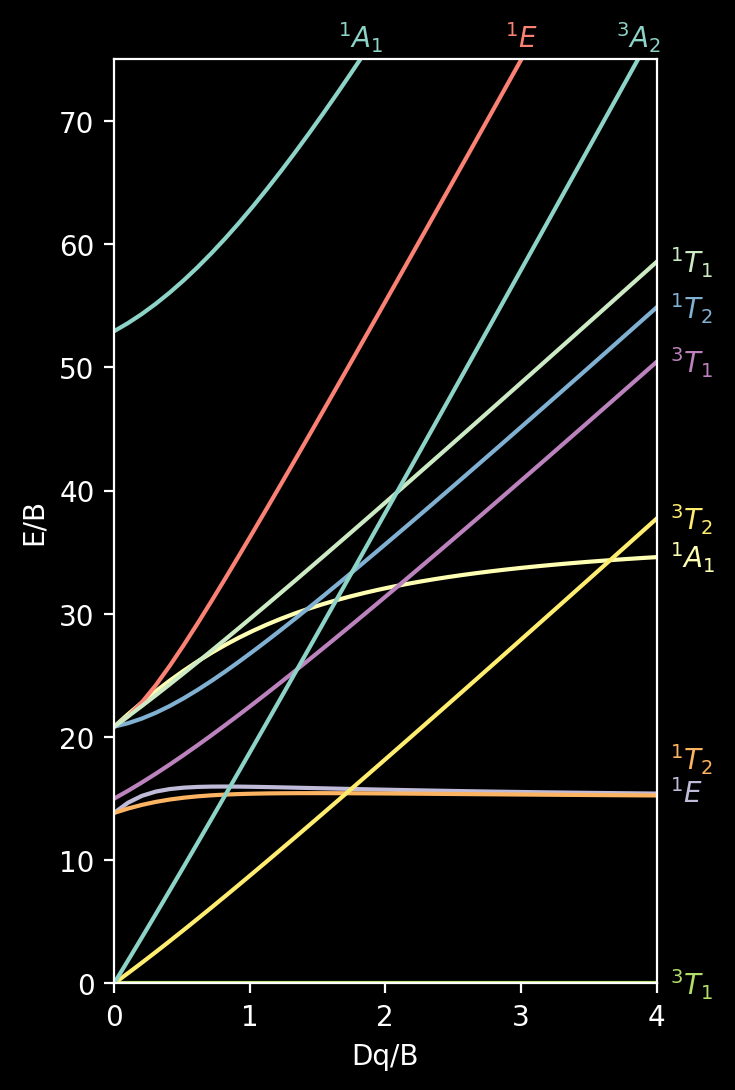

In [7]:
Dqs = np.linspace(0,4,40)
ymax = 75
γexp = 4.42
TSK_functions = TSK_diagrams[2]['numpy functions'] 
base = TSK_functions[(1, sp.Symbol('T_1'))][0](Dqs, γexp)
fig, ax = plt.subplots(figsize=(3.5, 6))
y_strs = []

for term_key, functions in TSK_functions.items():
    for function in functions:
        label_str = '${}^{%d}%s$' % (term_key[0]*2+1, sp.latex(term_key[1]))
        p = plt.plot(Dqs, function(Dqs, γexp) - base)
        col = p[0].get_color()
        y_str = function(Dqs[-1], γexp) - base[-1]
        if y_str < ymax:
            if len(y_strs)>0:
                if np.min(np.abs(np.array(y_strs)-y_str)) < 2:
                    y_str += 3
            ax.text(Dqs[-1]+0.1, y_str,label_str, c = col, va='center')
            y_strs.append(y_str)
        else:
            x_str = np.interp(ymax, function(Dqs, γexp) - base, Dqs)
            ax.text(x_str, ymax+1, label_str, c = col, ha ='center')
ax.set_xlim(0, Dqs[-1])
ax.set_ylim(0, ymax)
ax.set_xlabel('Dq/B')
ax.set_ylabel('E/B')
plt.show()

# Straightforward solution - TSK and standard basis agree

In [42]:
group_label = 'O'
l = 2
group = CPGs.get_group_by_label(group_label)
irreps = group.irrep_labels
sym_bases = {k: v[l] for k,v in symmetry_bases[group_label].items() if v[l]}
component_labels = {k:list(v.values()) for k,v in new_labels[group_label].items()}
basis_change = {}
for irrep, qets in sym_bases.items():
    components = component_labels[irrep]
    if isinstance(qets, list):
        qets = qets[0]
    for component, qet in zip(components, qets):
        basis_change[component] = qet


## 2e

In [177]:
l_splitter('C_{4v}',2)

Qet({A_1: 1, B_2: 1, B_1: 1, E: 1})

In [197]:
determine_irrep(sp.Symbol('{\\phi}'))

T_2

In [ ]:
def simple_energy(qnums, coeff):
    Dq = sp.Symbol('Dq')
    the_dict = {Dq:0}
    γ1, γ2 = qnums
    if γ1 == γ2:
        the_irrep = determine_irrep(γ1)
        if the_irrep == sp.Symbol('E'):
            the_dict[Dq] += coeff*6
        else:
            the_dict[Dq] += -coeff*4
    if the_dict[Dq] == 0:
        return {}
    return the_dict


In [6]:
crystal_splits = pickle.load(open('./data/crystal_splits.pkl','rb'))

In [256]:
eigen_system = crystal_splits[29]['eigen_system']
l = 2
basis_change = {}
eigen_counter = 0
for idx, eigen_part in enumerate(eigen_sys):
    eigen_size = eigen_part[0][1]
    print(eigen_size)
    for eigen_idx, eigen_vec in enumerate(eigen_part[0][2]):
        eigen_label = sp.Symbol('\\alpha_{%d}' % (eigen_counter))
        spherical_combo = Qet({(l,m): n for m,n in zip(range(-l,l+1),list(eigen_vec.T)) if n!= 0})
        normalizer = sp.S(1)/spherical_combo.norm()
        basis_change[eigen_label] = normalizer*spherical_combo
        eigen_counter += 1


3
3


In [325]:
crystal_splits[8]['eigen_system']

[]

In [320]:
# def TSK_matrix(num_electrons, group_label, l, slater_to_Racah = {}):
#     '''
#     A   straightforward  way  to  obtain  a  large  sparse  matrix  for  a
#     Hamiltonian  that  includes both a crystal field term and the pairwise
#     Coulomb repulsion.

#     This Hamiltonian only describes how the ground states is split both by
#     the crystal field and by the Coulomb repulsion.

#     The  Coulomb  repulsion appears as Slater integrals of several orders,
#     and  the  crystal  field  contribution as a function of the parameters
#     that parametrize it according to the corresponding group.

#     Parameters
#     ----------

#     num_electrons (int): how many electrons are there included.

#     group_label   (str): label for one of the 32

#     l             (int): angular momentum of pressumed ground state

#     to_Racah  (dict):  dictionary to map Slater integrals to Racah
#     parameters.

#     Returns
#     ------

#     ham  (sp.Matrix):  in  terms  of  Slater  integrals  F^{k}  (or  Racah
#     parameters  if  to_Racah is provided) and the crystal field parameters
#     adequate to the group.

#     '''
#     uID = (num_electrons, group_label, l, len(slater_to_Racah))

#     if uID in TSK_matrix.matrices:
#         return TSK_matrix.matrices[uID]

#     group_index = CPGs.all_group_labels.index(group_label) + 1

#     cf_field = crystal_splits[group_index]
#     eigen_sys = cf_field['eigen_system'][0]
#     Γs = l_splitter(group_label, l).dict
#     assert len(set(Γs.values())) == 1 and list(Γs.values())[0] == 1, "TODO"
#     Γs = tuple(Γs.keys())

#     basis_change = {}
#     eigen_counter = 0
#     basis_energies = {}
#     for eigen_part in eigen_sys:
#         eigen_energy = eigen_part[0]
#         for eigen_vec in eigen_part[2]:
#             eigen_label = sp.Symbol('\\alpha_{%d}' % (eigen_counter))
#             spherical_combo = Qet({(l,m): n for m,n in zip(range(-l,l+1),list(eigen_vec.T)) if n!= 0})
#             normalizer = sp.S(1)/spherical_combo.norm()
#             basis_change[eigen_label] = normalizer*spherical_combo
#             basis_energies[eigen_label] = eigen_energy
#             eigen_counter += 1

#     def simple_energy(qnums, coeff):
#         the_dict = {1:0}
#         γ1, γ2 = qnums
#         if γ1 == γ2:
#             the_dict[1] = coeff*basis_energies[γ1]
#         if the_dict[1] == 0:
#             return {}
#         return the_dict


#     single_e_basis = list(basis_change.keys())
#     # add spin up and spin down
#     spin_orbitals = single_e_basis + [bar_symbol(v) for v in single_e_basis]
#     # create determinantal states
#     slater_dets = list(combinations(spin_orbitals,num_electrons))
#     slater_qets = [Qet({k:1}) for k in slater_dets]
#     hamiltonian = {}

#     for idx0, qet0 in enumerate(slater_qets):
#         for idx1, qet1 in enumerate(slater_qets):
#             double_braket = double_electron_braket(qet0, qet1)
#             coulomb_matrix_element = braket_basis_change(double_braket, basis_change)
#             coulomb_matrix_element = coulomb_matrix_element.apply(to_slater_params)
#             coulomb_matrix_element = sp.expand(coulomb_matrix_element.as_symbol_sum())
#             crystal_field_energy = single_electron_braket(qet0, qet1).apply(simple_energy).as_symbol_sum()
#             matrix_element = coulomb_matrix_element + crystal_field_energy
#             if matrix_element != 0:
#                 hamiltonian[(idx0,idx1)] = matrix_element
#     hamiltonian = sp.simplify(sp.SparseMatrix(len(slater_qets), len(slater_qets), hamiltonian))

#     TSK_matrix.matrices[uID] = hamiltonian
#     return hamiltonian
# TSK_matrix.matrices = {}


In [420]:
# def TSK_matrix(num_electrons, group_label, l, slater_to_Racah = {}):
#     '''
#     A   straightforward  way  to  obtain  a  large  sparse  matrix  for  a
#     Hamiltonian  that  includes both a crystal field term and the pairwise
#     Coulomb repulsion.

#     This Hamiltonian only describes how the ground states is split both by
#     the crystal field and by the Coulomb repulsion.

#     The  Coulomb  repulsion appears as Slater integrals of several orders,
#     and  the  crystal  field  contribution as a function of the parameters
#     that parametrize it according to the corresponding group.

#     Parameters
#     ----------

#     num_electrons (int): how many electrons are there included.

#     group_label   (str): label for one of the 32

#     l             (int): angular momentum of pressumed ground state

#     to_Racah  (dict):  dictionary to map Slater integrals to Racah
#     parameters.

#     Returns
#     ------

#     ham  (sp.Matrix):  in  terms  of  Slater  integrals  F^{k}  (or  Racah
#     parameters  if  to_Racah is provided) and the crystal field parameters
#     adequate to the group.

#     '''
#     uID = (num_electrons, group_label, l, len(slater_to_Racah))

#     if uID in TSK_matrix.matrices:
#         return TSK_matrix.matrices[uID]

#     group_index = CPGs.all_group_labels.index(group_label) + 1

#     cf_field = crystal_splits[group_index]
#     crystal_basis = (len(cf_field['eigen_system']) > 0)
#     if crystal_basis:
#         eigen_sys = cf_field['eigen_system'][0]
#     # Γs = l_splitter(group_label, l).dict
#     # assert len(set(Γs.values())) == 1 and list(Γs.values())[0] == 1, "TODO"
#     # Γs = tuple(Γs.keys())

#     if crystal_basis:
#         basis_change = {}
#         eigen_counter = 0
#         basis_energies = {}
#         for eigen_part in eigen_sys:
#             eigen_energy = eigen_part[0]
#             for eigen_vec in eigen_part[2]:
#                 eigen_label = sp.Symbol('\\alpha_{%d}' % (eigen_counter))
#                 spherical_combo = Qet({(l,m): n for m,n in zip(range(-l,l+1),list(eigen_vec.T)) if n!= 0})
#                 normalizer = sp.S(1)/spherical_combo.norm()
#                 basis_change[eigen_label] = normalizer*spherical_combo
#                 basis_energies[eigen_label] = eigen_energy
#                 eigen_counter += 1
#         single_e_basis = list(basis_change.keys())
#         def simple_energy(qnums, coeff):
#             the_dict = {1:0}
#             γ1, γ2 = qnums
#             if γ1 == γ2:
#                 the_dict[1] = coeff*basis_energies[γ1]
#             if the_dict[1] == 0:
#                 return {}
#             return the_dict
#     else:
#         single_e_basis = [sp.Symbol('Y_{l,%d}' % (l,m)) for m in range(-l,l+1)]
#         basis_change = {sp.Symbol('Y_{l,%d}' % (l,m)):Qet({(l,m):1}) for m in range(-l,l+1)}
#         ham = cf_field['matrices'][0]
#         def simple_energy(qnums, coeff):
#             the_dict = {1:0}
#             γ1, γ2 = qnums
#             γ1idx = single_e_basis.index(γ1)
#             γ2idx = single_e_basis.index(γ2)
#             the_dict[1] = coeff*ham[γ1idx,γ2idx]
#             if the_dict[1] == 0:
#                 return {}
#             else:
#                 return the_dict

#     # add spin up and spin down
#     spin_orbitals = single_e_basis + [bar_symbol(v) for v in single_e_basis]
#     # create determinantal states
#     slater_dets = list(combinations(spin_orbitals,num_electrons))
#     slater_qets = [Qet({k:1}) for k in slater_dets]
#     hamiltonian = {}

#     for idx0, qet0 in enumerate(slater_qets):
#         for idx1, qet1 in enumerate(slater_qets):
#             double_braket = double_electron_braket(qet0, qet1)
#             coulomb_matrix_element = braket_basis_change(double_braket, basis_change)
#             coulomb_matrix_element = coulomb_matrix_element.apply(to_slater_params)
#             coulomb_matrix_element = sp.expand(coulomb_matrix_element.as_symbol_sum())
#             crystal_field_energy = single_electron_braket(qet0, qet1).apply(simple_energy).as_symbol_sum()
#             matrix_element = coulomb_matrix_element + crystal_field_energy
#             if matrix_element != 0:
#                 hamiltonian[(idx0,idx1)] = matrix_element
#     hamiltonian = sp.simplify(sp.SparseMatrix(len(slater_qets), len(slater_qets), hamiltonian))

#     TSK_matrix.matrices[uID] = hamiltonian
#     return hamiltonian
# TSK_matrix.matrices = {}


In [421]:
# mat = TSK_matrix(2,'O',2)
# mat = mat.subs(slater_to_Racah)

In [4]:
# def hamiltonian_CF_CR(num_electrons, group_label, l, sparse=False, force_standard_basis=False):
#     '''
#     Given  a  crystal field on an an ion with a given number of electrons,
#     this  function  provides  the  matrix that represents the hamiltionian
#     that includes the crystal field together with the Coulomb repulsion.

#     This  Hamiltonian only describes how the ground state is split both by
#     the  crystal  field  and by the Coulomb repulsion. The contribution to
#     the  total  energy,  as  provided  by the interaction with the nuclear
#     charge  does  not  figure  here, because it merely provides a constant
#     shift to all the energy levels included in this description.

#     In  all  cases  the  basis  used  in this matrix representation of the
#     Hamiltonian  is  composed  of  slater  determinants of single-electron
#     states.  If  force_standard_basis=True  then the angular part of these
#     states    is    given    by    standard    spherical    harmonic    if
#     force_standard_basis=False  then  the single-electron states are taken
#     as  the  eigenvectors of the single-electron crystal field. In forming
#     these slater determinants spin=1/2 is assumed.

#     The  Coulomb  repulsion appears as Slater integrals of several orders,
#     and  the  crystal  field  contribution as a function of the parameters
#     that parametrize it according to the corresponding symmetry group.

#     If  the crystal field for a single electron is possible to diagonalize
#     symbolically, then the basis used for the hamiltonian is an eigenbasis
#     for  it, if not, then the single-electron basis is simply the full set
#     of spherical harmonics for the given value of l  (multiplied by radial
#     parts that figure as the parameters of the model hamiltonian).

#     Parameters
#     ----------

#     num_electrons (int): how many electrons are there included.

#     group_label   (str): label for one of the 32

#     l             (int): angular momentum of pressumed ground state

#     sparse (Bool): if True then the returned matrix is sp.SparseMatrix

#     force_standard_basis  (Bool):  whether  to  force  use of the standard
#     spherical  harmonic basis, instead of allowing for the eigenvectors of
#     the crystal field to be used.

#     Returns
#     ------

#     hamiltonian  (sp.SparseMatrix): in terms of Slater integrals F^{k} (or
#     Racah  parameters  if  to_Racah  is  provided)  and  the crystal field
#     parameters adequate to the group.

#     basis_change  (OrderedDict): the keys being the labels used internally
#     for   calculations   and   the   values   being   Qets  understood  as
#     superpositions of spherical harmonics. This for  the  single  electron
#     states which are used to create multi-electron states.

#     slater_dets  (list):  a  list  of  symbols  that represents the slater
#     determinants  used for the basis in which the hamiltonian is computed,
#     in  here  a  symbol with a bar on top is understood to have spin down,
#     and  one  without  to have spin up (m=1/2). Together with basis_change
#     this could be used to generate the multi-electron determinantal states
#     in terms of slater determinants of spherical harmonics.

#     '''
#     uID = (num_electrons, group_label, l, sparse, force_standard_basis)

#     if uID in TSK_matrix.matrices:
#         return TSK_matrix.matrices[uID]

#     group_index = CPGs.all_group_labels.index(group_label) + 1

#     cf_field = crystal_splits[group_index]
#     crystal_basis = (len(cf_field['eigen_system']) > 0)
    
#     if crystal_basis:
#         eigen_sys = cf_field['eigen_system'][0]

#     if crystal_basis and not force_standard_basis:
#         print("Using crystal field basis.")
#         basis_change = OrderedDict()
#         eigen_counter = 0
#         basis_energies = {}
#         for eigen_part in eigen_sys:
#             eigen_energy = eigen_part[0]
#             for eigen_vec in eigen_part[2]:
#                 eigen_label = sp.Symbol('\\alpha_{%d}' % (eigen_counter))
#                 spherical_combo = Qet({(l,m): n for m,n in zip(range(-l,l+1),list(eigen_vec.T)) if n!= 0})
#                 normalizer = sp.S(1)/spherical_combo.norm()
#                 basis_change[eigen_label] = normalizer*spherical_combo
#                 basis_energies[eigen_label] = eigen_energy
#                 eigen_counter += 1
#         single_e_basis = list(basis_change.keys())
#         def simple_energy(qnums, coeff):
#             the_dict = {1:0}
#             γ1, γ2 = qnums
#             if γ1 == γ2:
#                 the_dict[1] = coeff*basis_energies[γ1]
#             if the_dict[1] == 0:
#                 return {}
#             return the_dict
#     else:
#         print("Using spherical harmonic basis.")
#         single_e_basis = [sp.Symbol('Y_{%d,%d}' % (l,m)) for m in range(-l,l+1)]
#         basis_change = OrderedDict([(sp.Symbol('Y_{%d,%d}' % (l,m)),Qet({(l,m):1})) for m in range(-l,l+1)])
#         ham = cf_field['matrices'][0]
#         def simple_energy(qnums, coeff):
#             the_dict = {1:0}
#             γ1, γ2 = qnums
#             γ1idx = single_e_basis.index(γ1)
#             γ2idx = single_e_basis.index(γ2)
#             the_dict[1] = coeff*ham[γ1idx,γ2idx]
#             if the_dict[1] == 0:
#                 return {}
#             else:
#                 return the_dict

#     # add spin up and spin down
#     single_e_spin_orbitals = single_e_basis + [bar_symbol(v) for v in single_e_basis]
#     # create determinantal states
#     slater_dets = list(combinations(single_e_spin_orbitals,num_electrons))
#     slater_qets = [Qet({k:1}) for k in slater_dets]
#     if sparse:
#         hamiltonian = {}
#     else:
#         hamiltonian = []

#     for idx0, qet0 in enumerate(slater_qets):
#         row = []
#         for idx1, qet1 in enumerate(slater_qets):
#             double_braket = double_electron_braket(qet0, qet1)
#             coulomb_matrix_element = braket_basis_change(double_braket, basis_change)
#             coulomb_matrix_element = coulomb_matrix_element.apply(to_slater_params)
#             coulomb_matrix_element = sp.expand(coulomb_matrix_element.as_symbol_sum())
#             crystal_field_energy = single_electron_braket(qet0, qet1).apply(simple_energy).as_symbol_sum()
#             matrix_element = coulomb_matrix_element + crystal_field_energy
#             if matrix_element != 0:
#                 if sparse:
#                     hamiltonian[(idx0,idx1)] = (matrix_element)
#                 else:
#                     row.append(matrix_element)
#             else:
#                 if not sparse:
#                     row.append(matrix_element)

#         if not sparse:
#             hamiltonian.append(row)
    
#     if sparse:
#         hamiltonian = (sp.SparseMatrix(len(slater_qets), len(slater_qets), hamiltonian))
#     else:
#         print(len(hamiltonian))
#         hamiltonian = sp.Matrix(hamiltonian)

#     TSK_matrix.matrices[uID] = (hamiltonian, basis_change, slater_dets)
#     return hamiltonian, basis_change, slater_dets
# TSK_matrix.matrices = {}


In [7]:
hamiltonian_CF_CR(3, 'O', 2, True, False)[1]

Using crystal field basis.


OrderedDict([(\alpha_{0}, Qet({(2, -1): 1})),
             (\alpha_{1}, Qet({(2, 1): 1})),
             (\alpha_{2}, Qet({(2, -2): -sqrt(2)/2, (2, 2): sqrt(2)/2})),
             (\alpha_{3}, Qet({(2, 0): 1})),
             (\alpha_{4}, Qet({(2, -2): sqrt(2)/2, (2, 2): sqrt(2)/2}))])

In [606]:
# sparse = False
# num_electrons = 3
# tsk1 = multi_electron_hamiltonian(num_electrons, 'O', 2, sparse, True)
# tsk1 = tsk1.subs(slater_to_Racah)
# tsk1 = tsk1.subs({sp.Symbol('A'): 0, 
#                   sp.Symbol('B_{4,0}'): 21*sp.Symbol('Dq'),
#                   sp.Symbol('B'): 1,
#                   sp.Symbol('C'): sp.Symbol('\\gamma_{CB}')})
# tsk1fun = sp.lambdify((sp.Symbol('\\gamma_{CB}'), sp.Symbol('Dq')), tsk1)

# Dqs = np.linspace(0,4,80)
# γexp = 4.50
# ymax = 75
# all_energies = []
# for Dq in Dqs:
#     if sparse:
#         energies = scipy.sparse.linalg.eigsh(tsk1fun(γexp, Dq),43)[0]
#     else:
#         energies = np.real(np.linalg.eigvals(tsk1fun(γexp, Dq)))
#     energies = np.sort(energies - np.min(energies))
#     all_energies.append(energies)
# all_energies = np.array(all_energies).T

# plt.figure(figsize=(3,6))
# for row in all_energies:
#     plt.plot(Dqs, row, 'r-')
# plt.ylim(0,ymax)
# plt.xlabel('Dq/B')
# plt.ylabel('E/B')
# plt.xlim(0,Dqs[-1])
# plt.show()

In [671]:
γexps = {2: 4.42, 3: 4.50, 4: 4.61, 5: 4.48, 6: 4.81, 7: 4.63, 8: 4.71}
Bexps =  {2: 860, 3:918 , 4:965 , 5:860, 6: 1065, 7: 971, 8:1030}
atoms = dict(zip([2,3,4,5,6,7,8], 'V,3 Cr,3 Mn,3 Mn,2 Co,3 Co,2 Ni,2'.split(' ')))
Dqs = np.linspace(0,4,80)
ymax = 75

In [672]:
# num_electrons = 3
# tsk1 = multi_electron_hamiltonian(num_electrons, 'O', 2, sparse, True)
# tsk1 = tsk1.subs(slater_to_Racah)
# tsk1 = tsk1.subs({sp.Symbol('A'): 0, 
#                   sp.Symbol('B_{4,0}'): 21*sp.Symbol('Dq'),
#                   sp.Symbol('B'): 1,
#                   sp.Symbol('C'): sp.Symbol('\\gamma_{CB}')})
# tsk1fun = sp.lambdify((sp.Symbol('\\gamma_{CB}'), sp.Symbol('Dq')), tsk1)

In [673]:
from matplotlib.colors import LogNorm

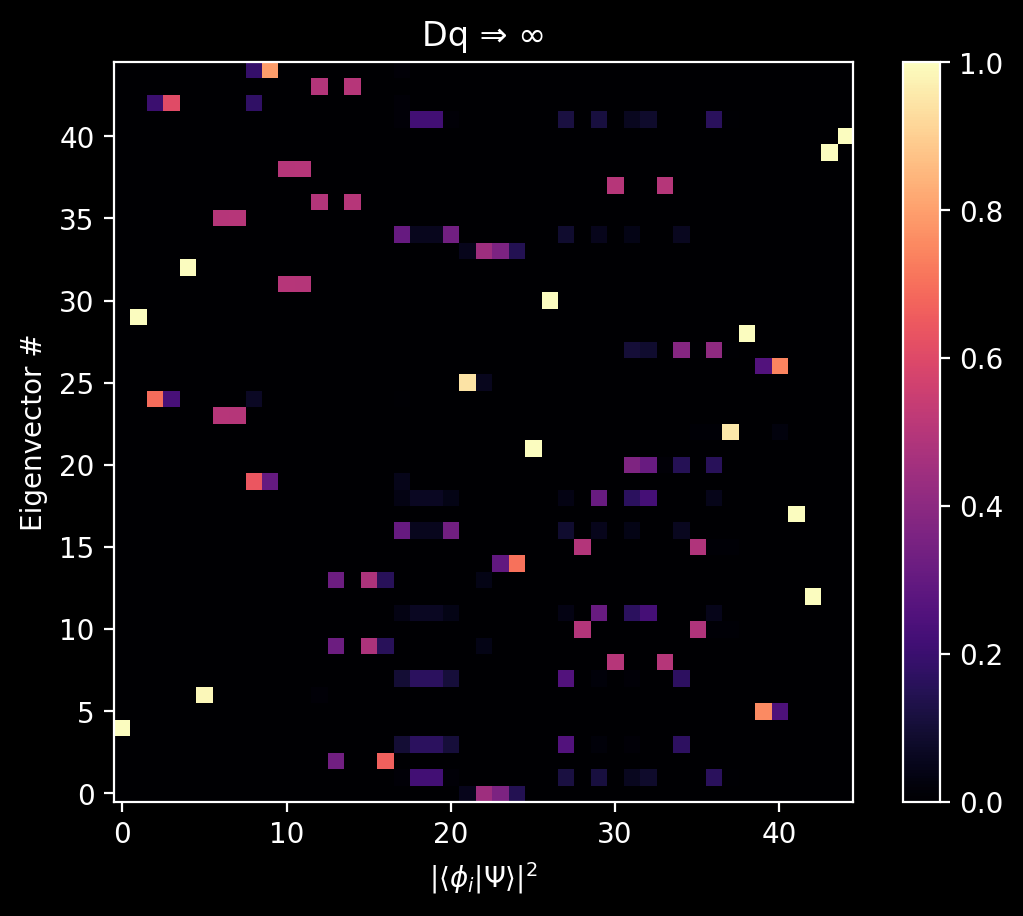

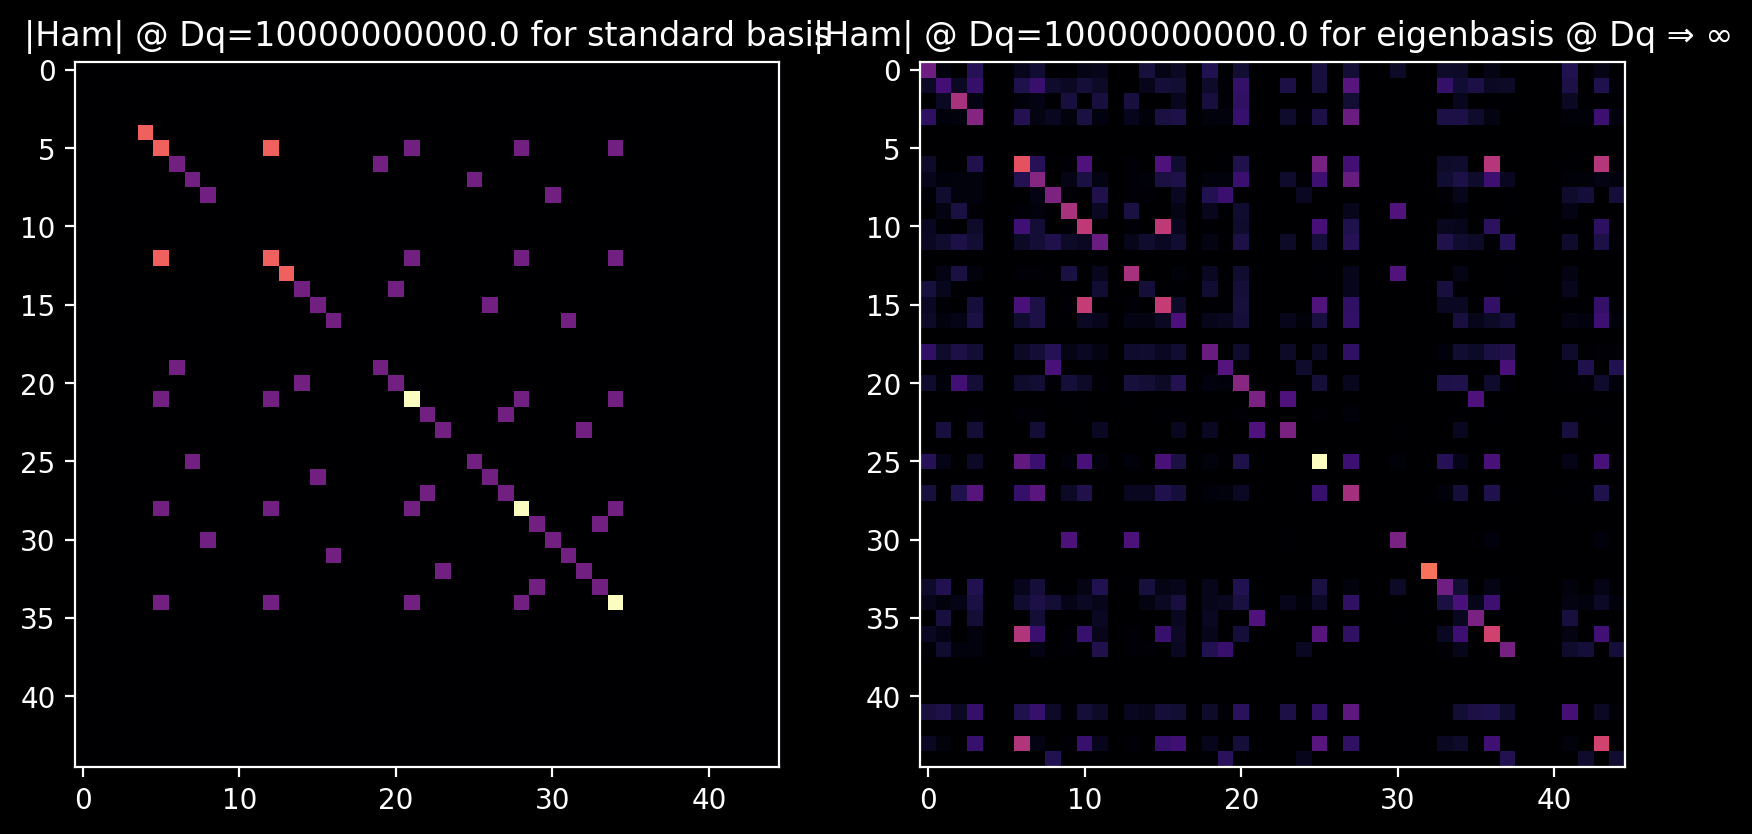

In [711]:
largeDq = 1e10
num_electrons = 2
sparse = False
probeDq = 1e10

hamiltonian = hamiltonian_CF_CR(num_electrons, 'O', 2, sparse, False)
hamiltonian = hamiltonian.subs(slater_to_Racah)
hamiltonian = hamiltonian.subs({sp.Symbol('A'): 0, 
                sp.Symbol('B_{4,0}'): 21*sp.Symbol('Dq'),
                sp.Symbol('B_{4,0}^r'): 21*sp.Symbol('Dq'),
                sp.Symbol('B'): 1,
                sp.Symbol('C'): sp.Symbol('\\gamma_{CB}')})
hamlambda = sp.lambdify((sp.Symbol('\\gamma_{CB}'), sp.Symbol('Dq')), hamiltonian)
eigensister = np.linalg.eig(hamlambda(γexp,largeDq))
eigenvals = np.real(eigensister[0])
sorter = np.argsort(eigenvals)
eigenvals = (eigenvals[sorter] - np.min(eigenvals))
eigenvects = eigensister[1][sorter]
# normalize them
eigenvects = np.array([eigv/np.sqrt(np.sum(eigv**2)) for eigv in eigenvects]).T
inverse_eigenvects = np.linalg.inv(eigenvects)

plt.figure()
plt.imshow(np.abs(eigenvects.T)**2, cmap='magma', origin='lower')
plt.colorbar()
plt.title('Dq ⇒ ∞')
plt.ylabel('Eigenvector #')
plt.xlabel(r'$|\langle \phi_i | \Psi\rangle|^2$')
plt.show()

fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(10,5))
axes[0].imshow(np.abs(hamlambda(probeDq,γexp)), cmap = 'magma')
axes[0].set_title('|Ham| @ Dq=%.1f for standard basis' % probeDq)
axes[1].imshow(np.abs(np.matmul(np.matmul(inverse_eigenvects,hamlambda(probeDq,γexp)),eigenvects)), cmap = 'magma')
axes[1].set_title('|Ham| @ Dq=%.1f for eigenbasis @ Dq ⇒ ∞' % probeDq)
# plt.colorbar()
plt.show()

N=2


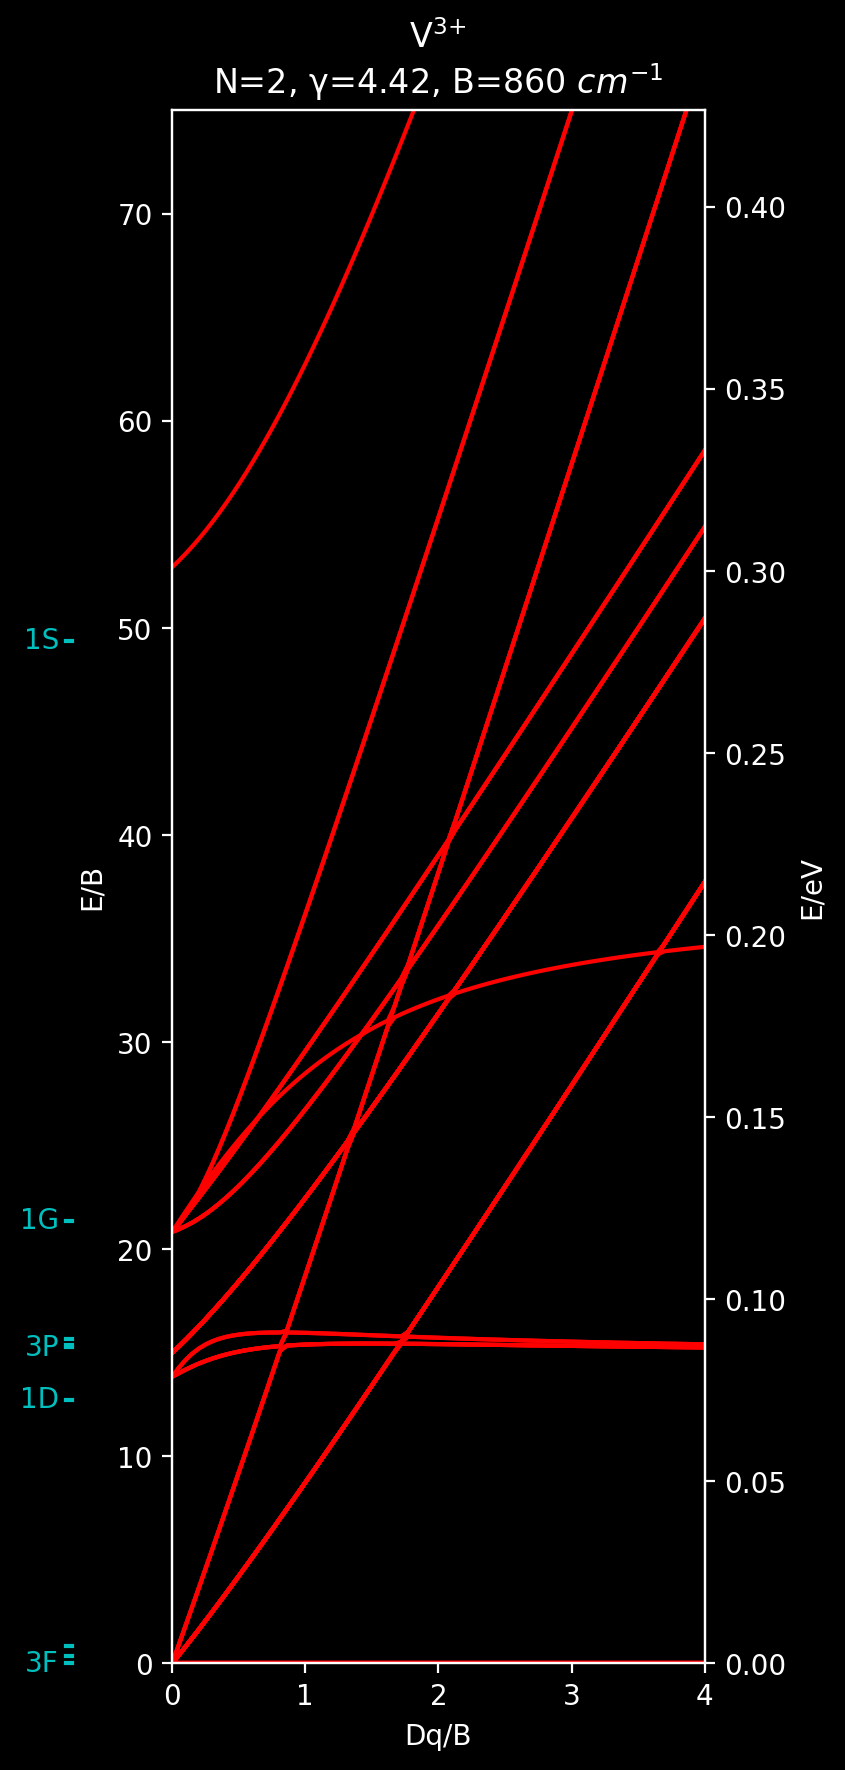

In [669]:
sparse = True
Dqs = np.linspace(0,4,80)
ymax = 75

for num_electrons in [2,3,4,5,6,7,8]:
    print('N=%d' % num_electrons)
    atom = atoms[num_electrons].split(',')[0]
    charge_state =  int(atoms[num_electrons].split(',')[1])
    γexp = γexps[num_electrons]
    ion = Ion(atom, charge_state)
    Bexp = Bexps[num_electrons]

    hamiltonian = hamiltonian_cf_cr(num_electrons, 'O', 2, sparse, True)
    hamiltonian = hamiltonian.subs(slater_to_Racah)
    hamiltonian = hamiltonian.subs({sp.Symbol('A'): 0, 
                  sp.Symbol('B_{4,0}'): 21*sp.Symbol('Dq'),
                  sp.Symbol('B'): 1,
                  sp.Symbol('C'): sp.Symbol('\\gamma_{CB}')})
    hamlambda = sp.lambdify((sp.Symbol('\\gamma_{CB}'), sp.Symbol('Dq')), hamiltonian)

    all_energies = []
    for Dq in Dqs:
        energies = np.real(np.linalg.eigvals(hamlambda(γexp, Dq).todense()))
        energies = np.sort(energies - np.min(energies))
        all_energies.append(energies)
    all_energies = np.array(all_energies).T

    exp_levels = ion.nist_data['Level (eV)'] * UnitCon.con_factor('eV','cm^{-1}')/Bexp
    term_labels =  ion.nist_data['Term']
    selector = exp_levels < ymax
    exp_levels = exp_levels[selector]
    term_labels = term_labels[selector]

    fig, ax = plt.subplots(figsize=(3*1.5,6*1.5))

    for row in all_energies:
        plt.plot(Dqs,row,'r')
    y_str = []
    first = True
    for exp_level, term_label in zip(exp_levels, term_labels):
        line = plt.Line2D([-0.8,-0.75],[exp_level]*2,c='c')
        line.set_clip_on(False)
        ax.add_line(line)
        if (len(y_str)>0 and min(([abs(ys - exp_level) for ys in y_str])) > 2) or first:
            plt.text(-.85,exp_level,term_label,ha='right', va='center', c='c')
            first = False
        y_str.append(exp_level)
    plt.xlim(0,Dqs[-1])
    plt.ylim(0,ymax)
    plt.xlabel('Dq/B')
    plt.ylabel('E/B')
    axright = ax.twinx()  # instantiate a second axes that shares the same x-axis
    axright.set_ylim(0, Dqs[-1]*Bexp*UnitCon.con_factor('cm^{-1}','eV'))
    axright.set_ylabel('E/eV')
    plt.title('%s${}^{%d\!+}$\nN=%d, γ=%.2f, B=%.0f $cm^{-1}$' % (atom, charge_state, num_electrons, γexp, Bexp))
    plt.tight_layout()
    # plt.savefig('TSK-%d.pdf' % num_electrons)
    plt.show()
    break

In [199]:
# def TSK_matrix_O_group(num_electrons, l, slater_to_Racah={}):
#     '''
#     A   straightforward  way  to  obtain  a  large  sparse  matrix  for  a
#     Hamiltonian  that  includes both a crystal field term and the pairwise
#     Coulomb repulsion.

#     This Hamiltonian only describes how the ground states is split both by
#     the crystal field and by the Coulomb repulsion.

#     Parameters
#     ----------

#     num_electrons (int): how many electrons are there included.

#     l             (int): angular momentum of pressumed ground state

#     to_Racah  (dict):  dictionary to map Slater integrals to Racah
#     parameters.

#     Returns
#     ------

#     ham  (sp.Matrix):  in  terms  of  Slater  integrals  F^{k}  (or  Racah
#     parameters  if  to_Racah is provided) and the crystal field parameters
#     adequate to the group.

#     '''
#     group_label = 'O'

#     uID = (num_electrons, group_label, l, len(slater_to_Racah))
#     if uID in TSK_matrix_O_group.matrices:
#         return TSK_matrix_O_group.matrices[uID]

#     # group = CPGs.get_group_by_label(group_label)
#     Γs = l_splitter(group_label, l).dict
#     assert len(set(Γs.values())) == 1 and list(Γs.values())[0] == 1, "TODO"
#     Γs = tuple(Γs.keys())

#     sym_bases = {k: v[l] for k,v in symmetry_bases[group_label].items() if v[l]}
#     component_labels = {k:list(v.values()) for k,v in new_labels[group_label].items()}
#     basis_change = {}
#     for irrep, qets in sym_bases.items():
#         components = component_labels[irrep]
#         if isinstance(qets, list):
#             qets = qets[0]
#         for component, qet in zip(components, qets):
#             basis_change[component] = qet
    
#     single_e_basis = []
#     for Γ in Γs:
#         single_e_basis.extend(component_labels[Γ])
#     # add spin up and spin down
#     spin_orbitals = single_e_basis + [bar_symbol(v) for v in single_e_basis]
#     # create determinantal states
#     slater_dets = list(combinations(spin_orbitals,num_electrons))
#     slater_qets = [Qet({k:1}) for k in slater_dets]
#     hamiltonian = []
    
#     for idx0, qet0 in enumerate(slater_qets):
#         row = []
#         for idx1, qet1 in enumerate(slater_qets):
#             double_braket = double_electron_braket(qet0, qet1)
#             coulomb_matrix_element = braket_basis_change(double_braket, basis_change)
#             coulomb_matrix_element = coulomb_matrix_element.apply(to_slater_params)
#             coulomb_matrix_element = sp.expand(coulomb_matrix_element.as_symbol_sum())
#             if len(slater_to_Racah) != 0:
#                 coulomb_matrix_element = coulomb_matrix_element.subs(slater_to_Racah)
#             if idx0 == idx1:
#                 crystal_field_energy = single_electron_braket(qet0, qet1).apply(simple_energy).as_symbol_sum()
#             else:
#                 crystal_field_energy = 0
#             row.append(coulomb_matrix_element + crystal_field_energy)
#         hamiltonian.append(row)
#     hamiltonian = sp.simplify(sp.Matrix(hamiltonian))
#     TSK_matrix_O_group.matrices[uID] = hamiltonian
#     return hamiltonian
# TSK_matrix_O_group.matrices = {}

In [ ]:
TSK_matrix_O_group(2, 2, slater_to_Racah)

In [175]:
TSK_matrix(2, (sp.Symbol('E'),sp.Symbol('T_2')), basis_change)

Matrix([
[A - 8*B + 12*Dq,              0,                     0,                     0,                     0,                   0,                   0,                    0,                    0,                   0,                      0,                     0,                   0,                     0,                      0,                     0,                      0,                        0,                        0,                   0,                      0,                    0,                       0,                        0,                   0,                    0,                     0,                       0,                    0,                        0,                    0,                      0,                        0,                        0,                    0,               0,              0,                     0,                     0,                   0,                      0,                     0,                        0,                  

In [96]:
def TSK_diagram(num_electrons, Dqs, γexp):
    hamiltonian = TSK_matrix(num_electrons)
    # after this replacement it should only be a function of Dq
    num_ham = hamiltonian.subs({sp.Symbol('A'):0, sp.Symbol('C'): sp.Symbol('\\gamma'), sp.Symbol('B'):1})
    num_ham = sp.lambdify((sp.Symbol('Dq'),sp.Symbol('\\gamma')), num_ham)
    eigen_array = []
    for Dq in Dqs:
        the_eigenvalues = np.sort(np.linalg.eig(num_ham(Dq, γexp))[0])
        the_eigenvalues = np.real(the_eigenvalues - np.min(the_eigenvalues))
        eigen_array.append(the_eigenvalues)
    eigen_array = np.array(eigen_array).T

    fig, ax = plt.subplots(figsize=(3*1.5,6*1.5))

    for row in eigen_array:
        plt.plot(Dqs,row,'r')
    plt.xlim(0,Dqs[-1])
    plt.ylim(0,ymax)
    plt.xlabel('Dq/B')
    plt.ylabel('E/B')
    axright = ax.twinx()  # instantiate a second axes that shares the same x-axis
    axright.set_ylim(0, Dqs[-1]*Bexp*UnitCon.con_factor('cm^{-1}','eV'))
    axright.set_ylabel('E/eV')
    plt.tight_layout()
    # plt.savefig('TSK-%d.pdf' % num_electrons)
    plt.show()

In [105]:
hamexp = TSK_matrix.matrices[3].subs({sp.Symbol('Dq'):0,sp.Symbol('A'):0,sp.Symbol('B'):1,sp.Symbol('A'):1})

In [152]:
bform = list(block_form(TSK_matrix(2)))

In [ ]:
for mat in bform[1]:
    display(mat)

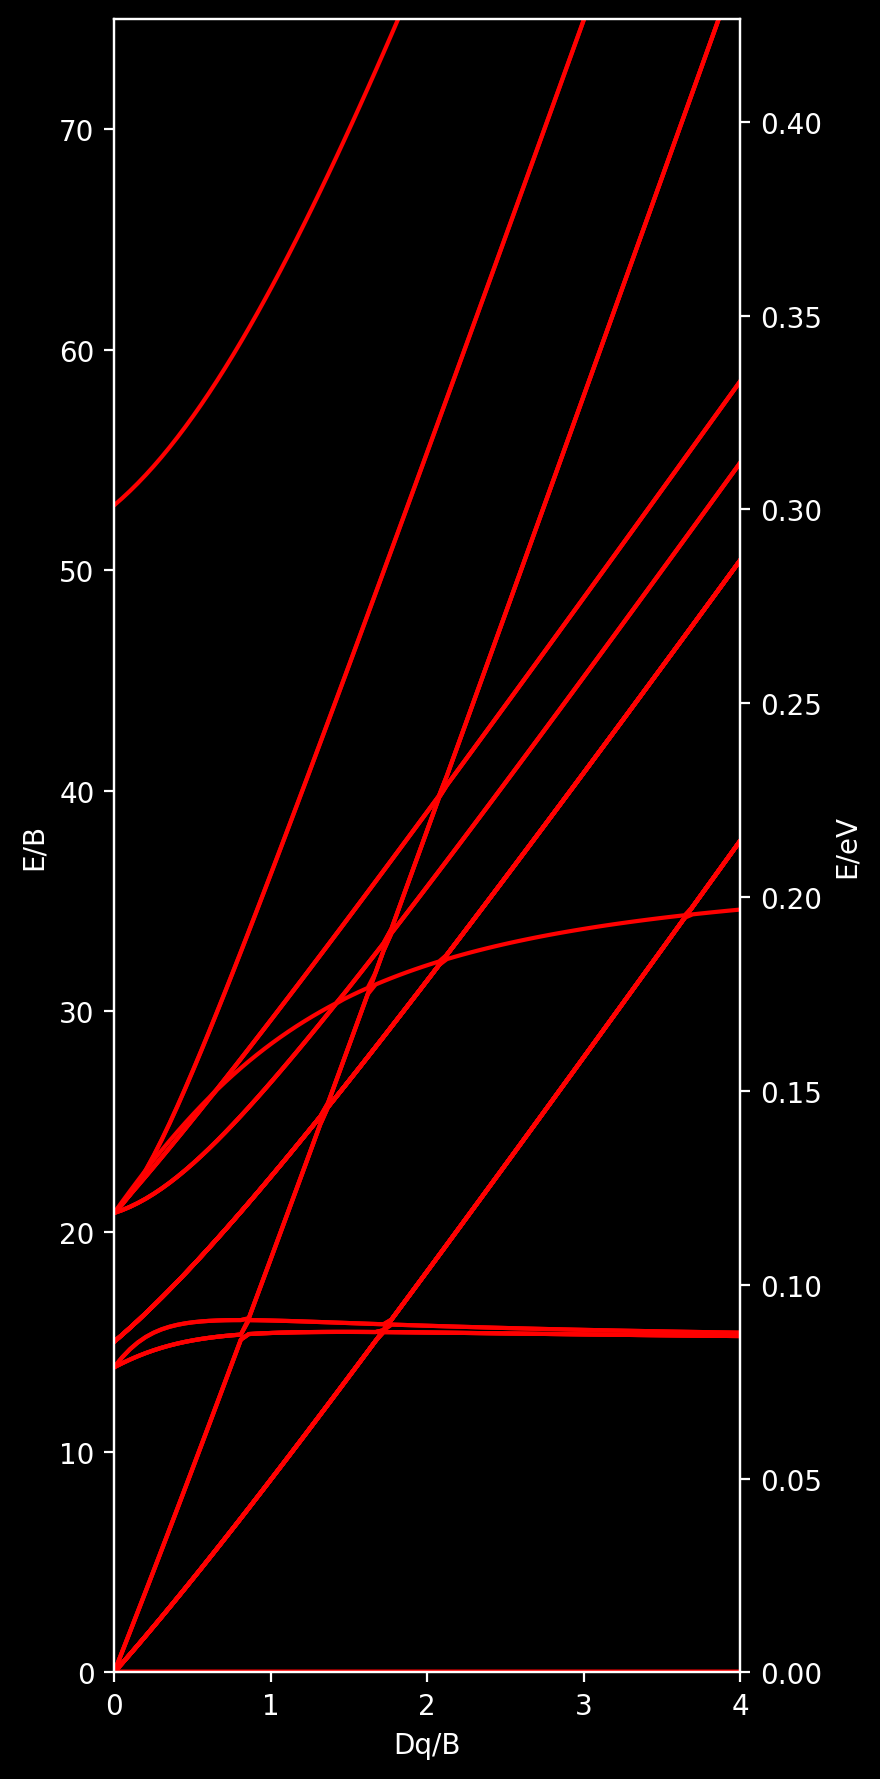

In [158]:
Dqs = np.linspace(0,4,80)
γexp = 4.42
fun = TSK_diagram(2,Dqs,γexp)

In [56]:
ham2 = TSK_matrix(2)

In [57]:
ham2 = TSK_matrix(2)

In [58]:
ham2.free_symbols

{A, B, C, Dq}

In [60]:
lham2 = sp.lambdify((sp.Symbol('A'),sp.Symbol('B'),sp.Symbol('C'),sp.Symbol('Dq')), ham2)

In [77]:
%%timeit
lham2(0,1,1,0)

912 µs ± 39 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [78]:
%%timeit
np.array(ham2.subs({sp.Symbol('A'):0,sp.Symbol('B'):1,sp.Symbol('C'):1,sp.Symbol('Dq'):0}))

180 ms ± 2.82 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


N=2


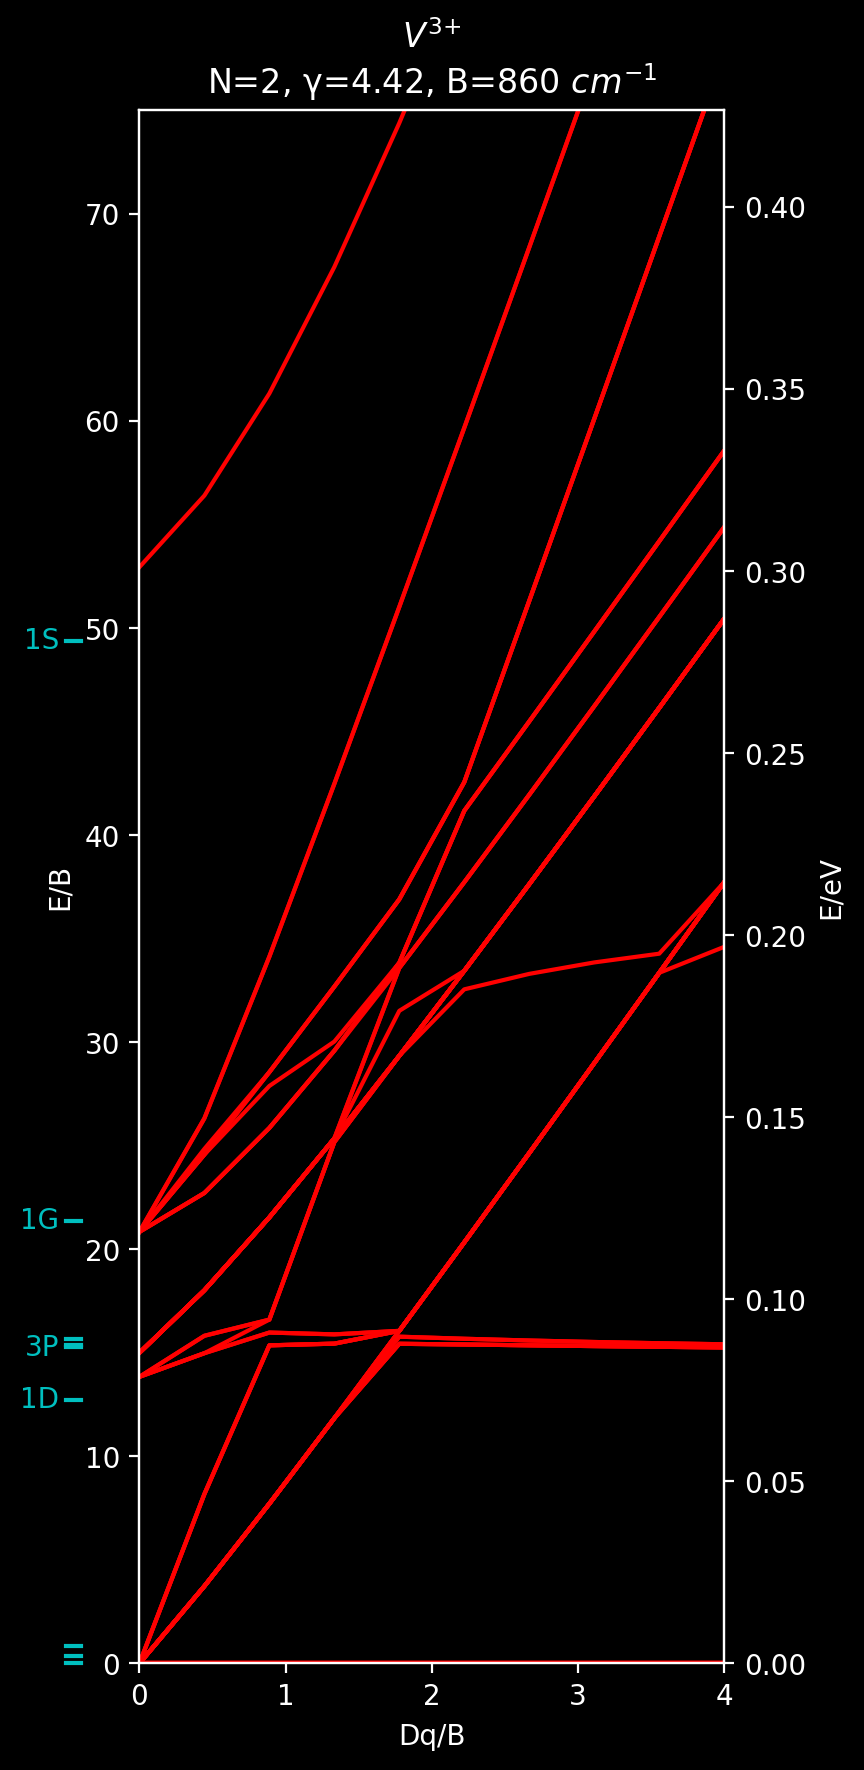

Timer unit: 1e-06 s

Total time: 41.8185 s
File: <ipython-input-26-c8112910594e>
Function: TSK at line 7

Line #      Hits         Time  Per Hit   % Time  Line Contents
     7                                           def TSK(num_electrons):
     8         1        138.0    138.0      0.0      print('N=%d' % num_electrons)
     9         1          6.0      6.0      0.0      atom = atoms[num_electrons].split(',')[0]
    10         1          4.0      4.0      0.0      charge_state =  int(atoms[num_electrons].split(',')[1])
    11         1          6.0      6.0      0.0      γexp = γexps[num_electrons]
    12         1      39648.0  39648.0      0.1      ion = Ion(atom, charge_state)
    13         1          7.0      7.0      0.0      Bexp = Bexps[num_electrons]
    14                                           
    15         1        747.0    747.0      0.0      single_e_basis = component_labels[sp.Symbol('E')] + component_labels[sp.Symbol('T_2')]
    16                              

In [27]:
%lprun -f TSK TSK(2)

In [28]:
!beep 

## 2 e

In [15]:
num_electrons = 2
single_e_basis = component_labels[sp.Symbol('E')] + component_labels[sp.Symbol('T_2')]
# add spin up and spin down
spin_orbitals = single_e_basis + [bar_symbol(v) for v in single_e_basis]
# create determinantal states
slater_dets = list(combinations(spin_orbitals,num_electrons))
slater_qets = [Qet({k:1}) for k in slater_dets]

In [16]:
hamiltonian = []
for qet0 in slater_qets:
    row = []
    for qet1 in slater_qets:
        double_braket = double_electron_braket(qet0,qet1)
        coulomb_matrix_element = braket_basis_change(double_braket, basis_change)
        coulomb_matrix_element = coulomb_matrix_element.apply(to_slater_params)
        coulomb_matrix_element = sp.expand(coulomb_matrix_element.as_symbol_sum()).subs(slater_to_Racah)
        nuclear_charge_energy = single_electron_braket(qet0,qet1).apply(simple_energy).as_symbol_sum()
        row.append(coulomb_matrix_element + nuclear_charge_energy)
    hamiltonian.append(row)
hamiltonian = sp.Matrix(hamiltonian)

In [17]:
γexp = 4.42
num_ham = hamiltonian.subs({sp.Symbol('A'):0, sp.Symbol('C'): γexp, sp.Symbol('B'):1})

In [18]:
# largeDq = 1e10
# the_ham_array = np.array(num_ham.subs({sp.Symbol('Dq'): largeDq})).astype(np.float64)
# the_eigenvalues = np.round(np.sort(np.linalg.eig(the_ham_array)[0])/largeDq)
# print(the_eigenvalues)

In [19]:
Dqs = np.linspace(0,4,80)
eigen_array = []
for Dq in Dqs:
    the_ham_array = np.array(num_ham.subs({sp.Symbol('Dq'): Dq})).astype(np.float64)
    the_eigenvalues = np.sort(np.linalg.eig(the_ham_array)[0])
    the_eigenvalues = np.real(the_eigenvalues - np.min(the_eigenvalues))
    eigen_array.append(the_eigenvalues)
eigen_array = np.array(eigen_array).T

TypeError: can't convert complex to float

In [75]:
ion = Ion('V',3)
Bexp = 860
exp_levels = ion.nist_data['Level (eV)'] * UnitCon.con_factor('eV','cm^{-1}')/Bexp
term_labels =  ion.nist_data['Term']
selector = exp_levels<ymax
exp_levels = exp_levels[selector]
term_labels = term_labels[selector]

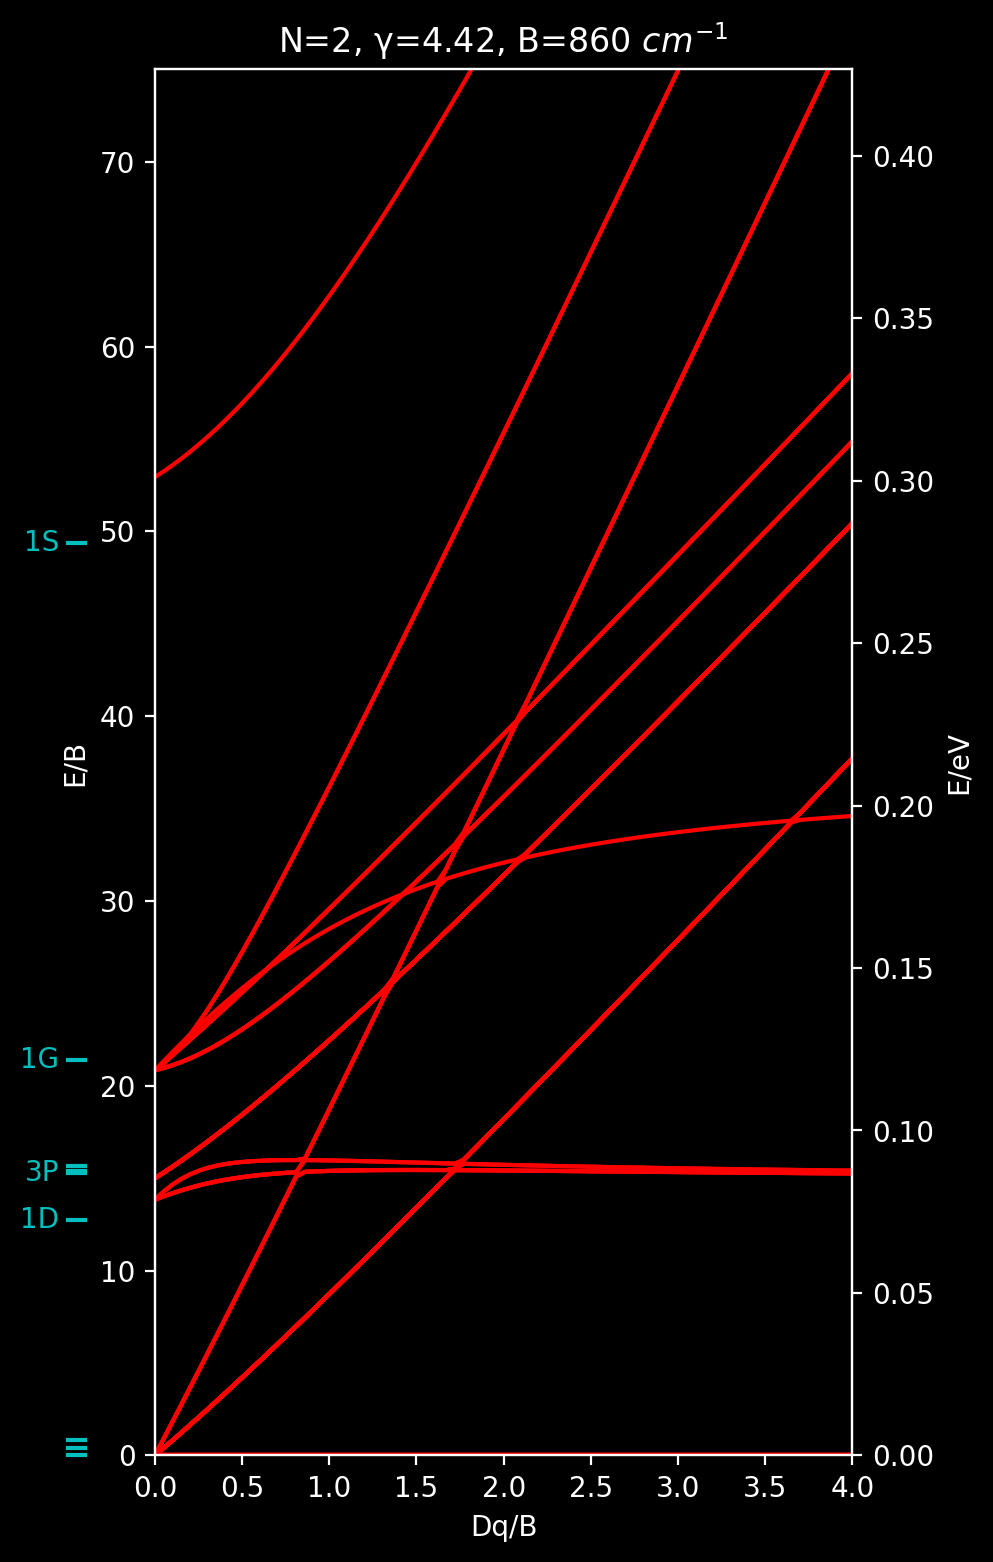

In [76]:
fig, ax = plt.subplots(figsize=(3*1.5,6*1.5))

for row in eigen_array:
    plt.plot(Dqs,row,'r')
y_str = []
for exp_level, term_label in zip(exp_levels, term_labels):
    line = plt.Line2D([-0.5,-0.4],[exp_level]*2,c='c')
    line.set_clip_on(False)
    ax.add_line(line)
    if len(y_str)>0 and min(([abs(ys - exp_level) for ys in y_str])) > 2:
        plt.text(-0.55,exp_level,term_label,ha='right', va='center', c='c')
    y_str.append(exp_level)
plt.xlim(0,Dqs[-1])
plt.ylim(0,ymax)
plt.xlabel('Dq/B')
plt.ylabel('E/B')
axright = ax.twinx()  # instantiate a second axes that shares the same x-axis
axright.set_ylim(0, Dqs[-1]*Bexp*UnitCon.con_factor('cm^{-1}','eV'))
axright.set_ylabel('E/eV')
plt.title('N=%d, γ=%.2f, B=%.0f $cm^{-1}$' % (num_electrons, γexp, Bexp))
plt.show()

## All TSK figures

N=2


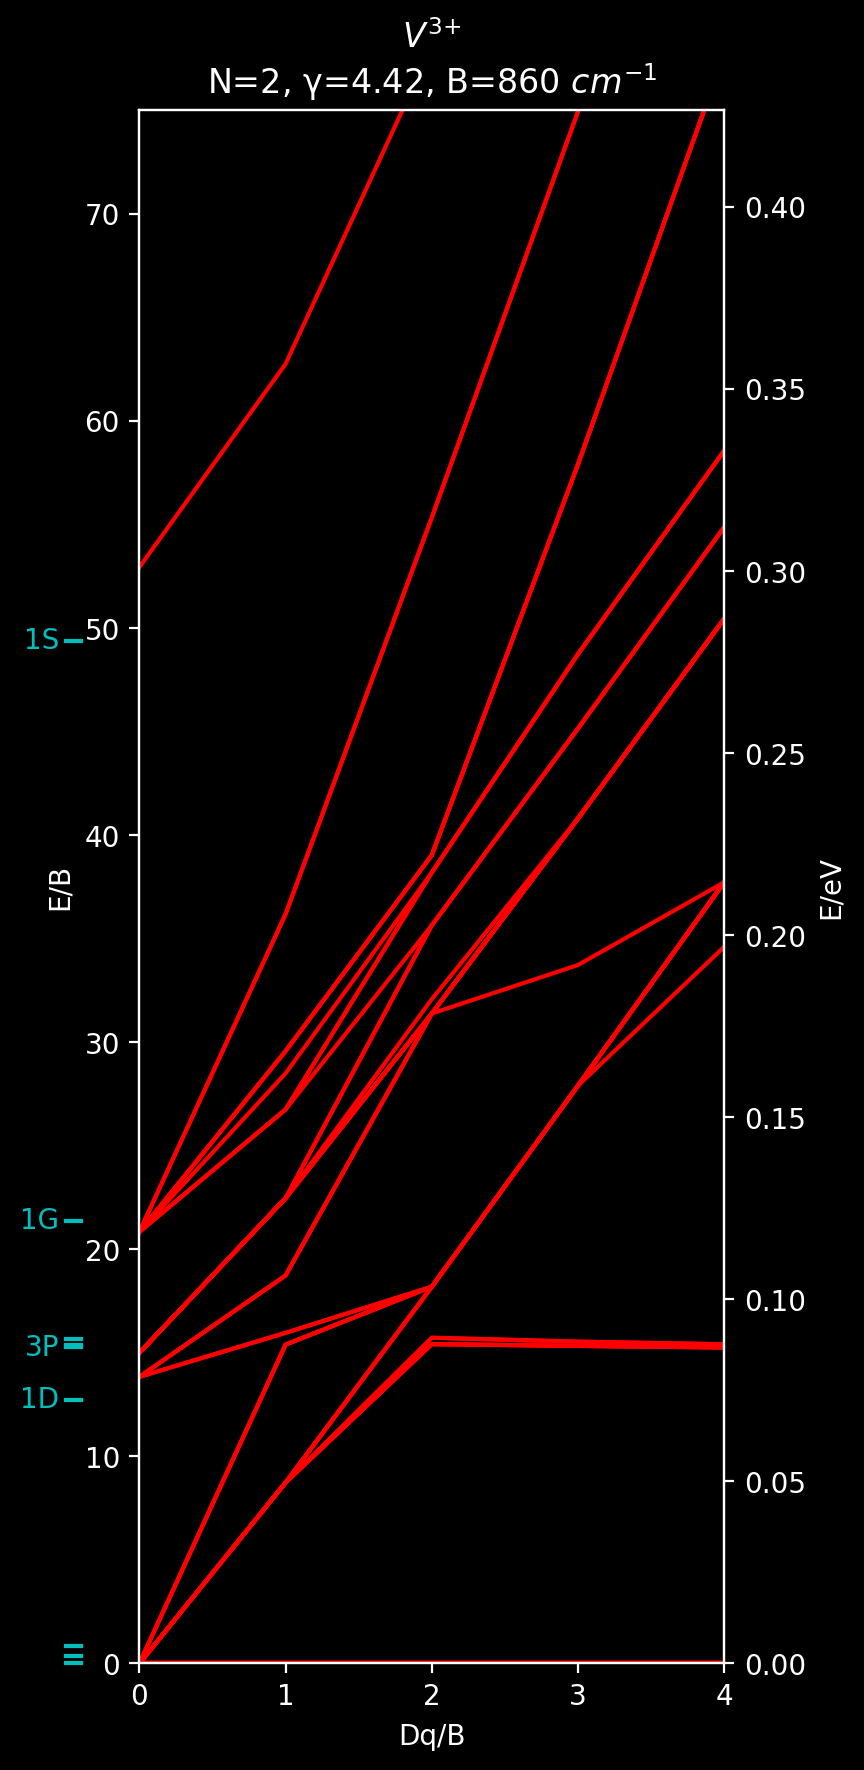

In [25]:
γexps = {2: 4.42, 3: 4.50, 4: 4.61, 5: 4.48, 6: 4.81, 7: 4.63, 8: 4.71}
Bexps =  {2: 860, 3:918 , 4:965 , 5:860, 6: 1065, 7: 971, 8:1030}
atoms = dict(zip([2,3,4,5,6,7,8], 'V,3 Cr,3 Mn,3 Mn,2 Co,3 Co,2 Ni,2'.split(' ')))
Dqs = np.linspace(0,4,40)
ymax = 75

for num_electrons in range(2,9):
    print('N=%d' % num_electrons)
    atom = atoms[num_electrons].split(',')[0]
    charge_state =  int(atoms[num_electrons].split(',')[1])
    γexp = γexps[num_electrons]
    ion = Ion(atom, charge_state)
    Bexp = Bexps[num_electrons]

    single_e_basis = component_labels[sp.Symbol('E')] + component_labels[sp.Symbol('T_2')]
    # add spin up and spin down
    spin_orbitals = single_e_basis + [bar_symbol(v) for v in single_e_basis]
    # create determinantal states
    slater_dets = list(combinations(spin_orbitals,num_electrons))
    slater_qets = [Qet({k:1}) for k in slater_dets]

    hamiltonian = []
    for qet0 in slater_qets:
        row = []
        for qet1 in slater_qets:
            double_braket = double_electron_braket(qet0,qet1)
            coulomb_matrix_element = braket_basis_change(double_braket, basis_change)
            coulomb_matrix_element = coulomb_matrix_element.apply(to_slater_params)
            coulomb_matrix_element = sp.expand(coulomb_matrix_element.as_symbol_sum()).subs(slater_to_Racah)
            nuclear_charge_energy = single_electron_braket(qet0,qet1).apply(simple_energy).as_symbol_sum()
            row.append(coulomb_matrix_element + nuclear_charge_energy)
        hamiltonian.append(row)
    hamiltonian = sp.Matrix(hamiltonian)
    num_ham = hamiltonian.subs({sp.Symbol('A'):0, sp.Symbol('C'): γexp, sp.Symbol('B'):1})

    eigen_array = []
    for Dq in Dqs:
        the_ham_array = np.array(num_ham.subs({sp.Symbol('Dq'): Dq})).astype(np.complex64)
        the_eigenvalues = np.sort(np.linalg.eig(the_ham_array)[0])
        the_eigenvalues = np.real(the_eigenvalues - np.min(the_eigenvalues))
        eigen_array.append(the_eigenvalues)
    
    eigen_array = np.array(eigen_array).T
    exp_levels = ion.nist_data['Level (eV)'] * UnitCon.con_factor('eV','cm^{-1}')/Bexp
    term_labels =  ion.nist_data['Term']
    selector = exp_levels<ymax
    exp_levels = exp_levels[selector]
    term_labels = term_labels[selector]

    fig, ax = plt.subplots(figsize=(3*1.5,6*1.5))

    for row in eigen_array:
        plt.plot(Dqs,row,'r')
    y_str = []
    for exp_level, term_label in zip(exp_levels, term_labels):
        line = plt.Line2D([-0.5,-0.4],[exp_level]*2,c='c')
        line.set_clip_on(False)
        ax.add_line(line)
        if len(y_str)>0 and min(([abs(ys - exp_level) for ys in y_str])) > 2:
            plt.text(-0.55,exp_level,term_label,ha='right', va='center', c='c')
        y_str.append(exp_level)
    plt.xlim(0,Dqs[-1])
    plt.ylim(0,ymax)
    plt.xlabel('Dq/B')
    plt.ylabel('E/B')
    axright = ax.twinx()  # instantiate a second axes that shares the same x-axis
    axright.set_ylim(0, Dqs[-1]*Bexp*UnitCon.con_factor('cm^{-1}','eV'))
    axright.set_ylabel('E/eV')
    plt.title('$%s^{%d\!+}$\nN=%d, γ=%.2f, B=%.0f $cm^{-1}$' % (atom, charge_state, num_electrons, γexp, Bexp))
    plt.tight_layout()
    # plt.savefig('TSK-%d.pdf' % num_electrons)
    plt.show()

# First Approach - The Big Dumb Matrix Approach

<center> 
This is a diagram for Vanadium IV, reproduce it. <br> <br>

<img src="notebook_imgs/2022-01-03-16-22-14.png" style="width: 25%;"/> 
</center>

Given a number of electrons in the d-subshell 
determine what are the possible configurations,

and then, as a function of Dq/B
it's easy to start from a free-ion term, and figure out how it would split under the crystal field
but since there are repeated terms, how would I know then from which free-ion term is can be
seen to have originated from?
If I were to set the crystal-field strength to zero, (which still leaves the Coulomb repulsion still on), this should
group the terms in groups that should belong to a single free-ion term, then I might be able to identify which one it is
by finding the match within the possible set of possibilities.
that is, I first need to obtain final

In [35]:
subs = {sp.Symbol('F_{(4)}') : sp.Symbol('F^{(4)}')/441,
        sp.Symbol('F_{(0)}'): sp.Symbol('F^{(0)}'),
        sp.Symbol('F_{(2)}'): sp.Symbol('F^{(2)}')/49}
A = sp.Symbol('F_{(0)}') - 49 * sp.Symbol('F_{(4)}')
A = A.subs(subs)
B = sp.Symbol('F_{(2)}') - 5 * sp.Symbol('F_{(4)}')
B = B.subs(subs)
C = 35*sp.Symbol('F_{(4)}')
C = C.subs(subs)
slater_to_Racah = sp.solve([sp.Symbol('A') - A, 
                        sp.Symbol('B') - B,
                        sp.Symbol('C') - C],(sp.Symbol('F^{(0)}'), sp.Symbol('F^{(2)}'), sp.Symbol('F^{(4)}')))

In [4]:
four_real_var_ids, four_symbol_ids, two_real_var_ids, two_symbol_ids, simplifier = braket_identities('O', assume_real = False, verbose = True)

O Creating all 4-symbol identities ...
O Refining set of identities ...
O Finding trivial zeros ...
O Using them to simplify things ...
O Creating reality identities ...
O Solving for independent 4-symbol brakets ...
O Creating a dictionary with all the 4-symbol replacements ...
O Creating all 2-symbol identities ...
O Creating set of 2 symbol identities ...
O Finding trivial zeros ...
O Using them to simplify things ...
O Creating reality identities ...
O Solving for independent 2-symbol brakets ...
O Creating a dictionary with all the 2-symbol replacements ...


In [348]:
group_label = 'O'
l = 2
group = CPGs.get_group_by_label(group_label)
irreps = group.irrep_labels
sym_bases = {k: v[l] for k,v in symmetry_bases[group_label][1].items() if v[l]}
component_labels = {k:list(v.values()) for k,v in new_labels[group_label].items()}
basis_change = {}
for irrep, qets in sym_bases.items():
    components = component_labels[irrep]
    if isinstance(qets, list):
        qets = qets[0]
    for component, qet in zip(components, qets):
        basis_change[component] = qet
# basis_change[sp.Symbol('{\\xi}')] = - basis_change[sp.Symbol('{\\xi}')]


In [349]:
two_electrons = []
for config in config_layout('O', 2, 2):
    Γ1s = config[0]
    if len(config) == 1:
        Γ2s = []
    else:
        Γ2s = config[1]
    two_electrons.append((config,CrystalElectronsLLCoupling('O', Γ1s, Γ2s)))

In [350]:
terms = {}
for wave_key, wave_qet in two_electrons[1][1].equiv_waves.items():
    aterm = wave_key.terms[-1]
    if aterm not in terms:
        terms[aterm] = {}
    terms[aterm][wave_key] = wave_qet
terms = OrderedDict(sorted(list(terms.items()), key=lambda x: x[0][0]))

In [351]:
all_terms = OrderedDict()
Λ = namedtuple('Λ',['electrons','term','γ']) 
for two_e_config in two_electrons:
    for wave_key, wave_qet in two_e_config[1].equiv_waves.items():
        λ = Λ(electrons=tuple(two_e_config[0]),term=wave_key.terms[-1], γ = wave_key.γ)
        term_sector = wave_key.terms[-1][1]
        component_pivot = component_labels[term_sector][0]
        if λ not in all_terms and component_pivot == wave_key.γ:
            all_terms[λ] = (wave_key, wave_qet)
        # all_terms[λ] = (wave_key, wave_qet)

<center> <img src="notebook_imgs/2022-01-05-11-35-51.png" style="width: 50%;"/> </center>

This in turn simplifies to 6 <ξη||ζu> = 6 B = 6/49 F^2 - 10/147 F^4

In [364]:
energy_matrix = []
term_keys = list(all_terms.keys())
term_keys = sorted(term_keys, key = lambda x: str(x.term[1]))
gamma_ratio = {sp.Symbol('C'): sp.Symbol('\\gamma_{CB}') * sp.Symbol('B')}
for λ0 in term_keys:
    row = []
    qet_key_0 = all_terms[λ0][0]
    qet_0 = all_terms[λ0][1]
    for λ1 in term_keys:
        qet_key_1 = all_terms[λ1][0]
        qet_1 = all_terms[λ1][1]
        matrix_element = double_electron_braket(qet_0,qet_1)
        matrix_element = simplifier(matrix_element)
        matrix_element = braket_basis_change(matrix_element, basis_change)
        matrix_element = matrix_element.apply(to_slater_params)
        mat_element = sp.expand(matrix_element.as_symbol_sum()).subs(slater_to_Racah)
        mat_element = mat_element.subs(gamma_ratio)
        single_elec_element = single_electron_braket(qet_0, qet_1).apply(another_simplifier).as_symbol_sum()
        row.append(mat_element + single_elec_element)
    energy_matrix.append(row)
energy_matrix = sp.Matrix(energy_matrix)

NOTE: A doesn't matter 'cause it just raises all the energies by the same amount. At least on this example.

In [365]:
ts2gtkv = [l.strip() for l in open("/Users/juan/Zia Lab/Codebase/qdef/data/tsdiag2.txt",'r').readlines()];
ts2gtk = ts2gtkv[::2]
ts2gtv = [np.array(eval(l)) for l in ts2gtkv[1::2]]

In [366]:
zeroCF = list((energy_matrix.subs({sp.Symbol('A'):0,sp.Symbol('B_{4,0}'):0,sp.Symbol('B'):1}).eigenvals()).items())
zeroCF = list(sorted(zeroCF, key = lambda x: x[0].subs({sp.Symbol('\\gamma_{CB}'):γexp})))
zeroCF = [(k-zeroCF[0][0],v) for k,v in zeroCF]

In [367]:
a_Bohr = 5.29e-11 * 100 # in cm
e_squared = (4.80320425e-10)**2 # in erg X cm
# γexp = 4.42
# Bexp = 860
γexp = 4.42
Bexp = 860
# to convert slater integrals to energies in cm^{-1}
con_fact = e_squared/a_Bohr*UnitCon.con_factor('erg','cm^{-1}') 
Fddreps = {sp.Symbol('F^{(%d)}' % k) : con_fact*SlaterFddSTK(k,1) for k in [0,2,4]}

# replace in favor of
energy_matrix_rep = energy_matrix.subs({sp.Symbol('B_{4,0}'): 21 * sp.Symbol('Dq')})
# divide matrix by B
energy_matrix_rep = sp.expand(energy_matrix_rep/sp.Symbol('B'))
# replace by Bexp
subs = {sp.Symbol('B'): Bexp, sp.Symbol('\\gamma_{CB}'): γexp, sp.Symbol('A'): 0*A.subs(Fddreps)}
energy_matrix_rep = energy_matrix_rep.subs(subs)


In [368]:
# checking asymptotic behaviour
largeDq = 1e100
this_em = energy_matrix_rep.subs({sp.Symbol('Dq'):largeDq})
this_em = np.array(this_em).astype(np.float64)
eigenvals, eigenvects = np.linalg.eig(this_em)
eigenvals = np.sort(eigenvals)/largeDq
eigenvals = eigenvals - np.min(eigenvals)
eigenvals = Bexp*eigenvals
np.round(eigenvals,2)

array([ 0.,  0.,  0.,  0., 10., 10., 10., 10., 20., 20., 20.])

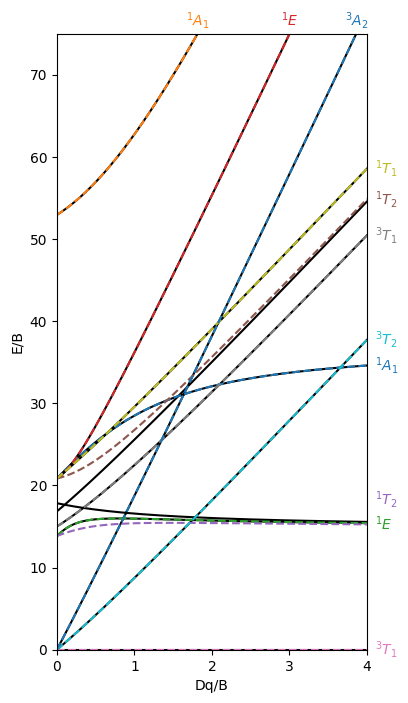

In [369]:
Dqs = np.linspace(0, 4*Bexp, 200)
diagram = []
all_eigenvects = []
ymax = 75
for Dq in Dqs:
    this_em = energy_matrix_rep.subs({sp.Symbol('Dq'):Dq})
    this_em = np.array(this_em).astype(np.float64)
    eigenvals, eigenvects = np.linalg.eig(this_em)
    sorter = np.argsort(eigenvals)
    eigenvals = eigenvals[sorter]
    eigenvects = eigenvects[sorter]
    diagram.append(eigenvals)
    all_eigenvects.append(eigenvects)
diagram = np.array(diagram).T
plt.figure(figsize=(4,8))
row0 = diagram[0]
for row in diagram:
    plt.plot(Dqs/Bexp, row-row0,'k-')
# for tsgt, label in zip(ts2gtv,ts2gtk):
#     plt.plot(tsgt[:,0],tsgt[:,1],'--', label=label)

Dqsr = np.linspace(0, 4, 200)
base = TSK_functions[(1,sp.Symbol('T_1'))][0](Dqsr, γexp)
y_strs = []
for term_key, functions in TSK_functions.items():
    for function in functions:
        label_str = '${}^{%d}%s$' % (term_key[0]*2+1,sp.latex(term_key[1]))
        p = plt.plot(Dqsr, function(Dqsr, γexp) - base, '--')
        col = p[0].get_color()
        y_str = function(Dqsr[-1], γexp) - base[-1]
        if y_str < ymax:
            if len(y_strs)>0:
                if np.min(np.abs(np.array(y_strs)-y_str)) < 2:
                    y_str += 3
            plt.text(Dqsr[-1]+0.1, y_str,label_str, c = col, va='center')
            y_strs.append(y_str)
        else:
            x_str = np.interp(ymax, function(Dqsr, γexp) - base, Dqsr)
            plt.text(x_str, ymax+1, label_str, c = col, ha ='center')

plt.ylim(0,ymax)
plt.xlim(Dqs[0]/Bexp,Dqs[-1]/Bexp)
plt.xlabel('Dq/B')
plt.ylabel('E/B')
plt.show()

## Trunk 

In [70]:
# # building the full configuration matrix
# energy_matrix = []
# for term_0, term_qets_0 in terms.items():
#     term_symbol_0 = sp.Symbol('{}^{%d}%s' % (term_0[0]*2+1, sp.latex(term_0[1])))
#     a_key_0 = list(term_qets_0.keys())[0]
#     a_qet_0 = term_qets_0[a_key_0]
#     row = []
#     for term_1, term_qets_1 in terms.items():
#         term_symbol_1 = sp.Symbol('{}^{%d}%s' % (term_1[0]*2+1, sp.latex(term_1[1])))
#         a_key_1 = list(term_qets_1.keys())[0]
#         a_qet_1 = term_qets_1[a_key_1]
#         matrix_element = double_electron_braket(a_qet_0,a_qet_1)
#         matrix_element = simplifier(matrix_element)
#         # display(Math(r'%s \rightarrow %s' % (sp.latex(term_symbol),sp.latex(matrix_element.as_braket()))))
#         matrix_element = braket_basis_change(matrix_element, basis_change)
#         # display(Math(r'%s \rightarrow %s' % (sp.latex(term_symbol),sp.latex(matrix_element.as_braket()))))
#         # display(matrix_element.as_braket())
#         matrix_element = matrix_element.apply(to_slater_params)
#         for electron in a_key.electrons:
#             cf_energy = sp.Symbol('E_{CF}(%s)' % (sp.latex(electron).lower()))
#             matrix_element = matrix_element + Qet({cf_energy:1})
#         # cf_energy = sp.Symbol('E_{CF}(%s, %s, %s)' % (sp.latex(a_key.electrons).lower(),sp.latex(a_key.terms[-1]),sp.latex(a_key.γ)))
#         # matrix_element = matrix_element + Qet({cf_energy:1})
#         # display(Math(r'%s \rightarrow %s' % (sp.latex(term_symbol),sp.latex(matrix_element.as_symbol_sum()))))
#         row.append(matrix_element.as_symbol_sum())
#     energy_matrix.append(row)
# energy_matrix = sp.Matrix(energy_matrix)

In [ ]:
# # test of three harmonic integral
# "ll' mm' k"
# inputstrings = ['s p 0 1 1', 'p d 1 2 1', 's f 0 3 3', 'd f 2 3 1' ,'d f 2 3 3', 's s 0 0 0', 's d 0 2 2', 'p p 1 1 2', 'p f 1 3 2', 'd f 2 2 3', 'f f 3 -3 6']
# gts = [-sp.S(1)/sp.sqrt(3), -sp.sqrt(6)/sp.sqrt(15), -1/sp.sqrt(7), -sp.sqrt(15)/sp.sqrt(35), sp.sqrt(10)/(sp.sqrt(35)*3), 1, 1/sp.sqrt(5), -1/sp.S(5), 3*sp.sqrt(5)/(5*sp.sqrt(7)), -2*sp.sqrt(5)/(3*sp.sqrt(35)), -10*sp.sqrt(231)/429]
# for gt, inputstring in zip(gts, inputstrings):
#     l, lp, m, mp, k = inputstring.split(' ')
#     m = int(m)
#     mp = int(mp)
#     k = int(k)
#     mk = m - mp
#     l, lp = [{'s':0,'p':1,'d':2,'f':3}[el] for el in [l,lp]]
#     val = sp.sqrt((4*sp.pi) / (2*k+1)) * threeHarmonicIntegral(l,m,k,mk,lp,mp)
#     if val == gt:
#         print("|✓|", val,)
#     else:
#         print(l, lp, m, mp, k , '|',inputstring, '|', val, gt)

In [ ]:
# basis_change_raw = dict(basis_change)
# # sign tweaking
# irrep = sp.Symbol('T_1')
# good_signs = []
# for sign_gauge in product(*[[-1,1]]*5):
#     basis_change = dict(basis_change_raw)
#     counter = 0
#     for k in basis_change:
#         basis_change[k] = sign_gauge[counter]*basis_change[k]
#         # basis_change[k] = choice([-1,1])*basis_change[k]
#         counter += 1
#     good_counter = 0
#     for component in component_labels[irrep]:
#         # if component != sp.Symbol('{\\mu}'):
#         #     continue
#         # display(component)
#         a_term = []
#         # Λ = namedtuple('Λ',['electrons','term'])
#         agamma = ''
#         for two_e_config in two_electrons:
#             for wave_key, wave_qet in two_e_config[1].equiv_waves.items():
#                 if wave_key.terms[-1] != (1,irrep):
#                     continue
#                 if wave_key.γ != component:
#                     continue
#                 if wave_key.M != 0:
#                     continue
#                 a_term.append((wave_key,wave_qet))
#         # print("len",len(a_term))
#         bra = a_term[0][1]
#         ket = a_term[1][1]
#         # display(bra.as_ket())
#         # display(ket.as_ket())
#         # print("bra",a_term[0][0])
#         # print("ket",a_term[1][0])
#         abraket = simplifier(double_electron_braket(bra,ket))
#         final_braket = braket_basis_change(abraket, basis_change).apply(to_slater_params)
#         # print(final_braket.dict[sp.Symbol('F^{(2)}')])
#         if(final_braket.dict[sp.Symbol('F^{(2)}')] == sp.S(6)/49):
#             if(final_braket.dict[sp.Symbol('F^{(4)}')] == -sp.S(10)/147):
#                 good_counter += 1
#     if good_counter == 3:
#         good_signs.append(sign_gauge)
    

In [ ]:
# for k, v in basis_change.items():
#     display(k)
#     display(v.as_ket())

In [ ]:
# # The diagonal is correct
# display(simplifier(double_electron_braket(bra,bra)).as_braket())
# display(simplifier(double_electron_braket(ket,ket)).as_braket())

In [ ]:
# Bexp = 860
# shifts = {Λ(electrons=((sp.Symbol('T_2'), 2),), term=(0, sp.Symbol('A_1'))): Bexp*20,
#  Λ(electrons=((sp.Symbol('T_2'), 2),), term=(0, sp.Symbol('E'))): Bexp*12,
#  Λ(electrons=((sp.Symbol('T_2'), 2),), term=(1, sp.Symbol('T_1'))): Bexp*0,
#  Λ(electrons=((sp.Symbol('T_2'), 2),), term=(0, sp.Symbol('T_2'))): Bexp*12,
#  Λ(electrons=((sp.Symbol('E'), 1), (sp.Symbol('T_2'), 1)), term=(1, sp.Symbol('T_2'))): Bexp*0,
#  Λ(electrons=((sp.Symbol('E'), 1), (sp.Symbol('T_2'), 1)), term=(1, sp.Symbol('T_1'))): Bexp*15,
#  Λ(electrons=((sp.Symbol('E'), 1), (sp.Symbol('T_2'), 1)), term=(0, sp.Symbol('T_2'))): Bexp*10,
#  Λ(electrons=((sp.Symbol('E'), 1), (sp.Symbol('T_2'), 1)), term=(0, sp.Symbol('T_1'))): Bexp*20,
#  Λ(electrons=((sp.Symbol('E'), 2),), term=(0, sp.Symbol('A_1'))): Bexp*52,
#  Λ(electrons=((sp.Symbol('E'), 2),), term=(0, sp.Symbol('E'))): Bexp*20,
#  Λ(electrons=((sp.Symbol('E'), 2),), term=(1, sp.Symbol('A_2'))): Bexp*0
#  }

In [ ]:
# def determine_irrep(component):
#     matches = [ir for ir, comps in component_labels.items() if component in comps]
#     if len(matches) == 1:
#         return matches[0]
#     else:
#         raise Exception("Invalid component")

# def a_simplifier(qnums, coeff):
#     l1, m1, l2, m2 = qnums
#     if m1 == m2:
#         return {(1,): coeff}
#     else:
#         return {}

# def another_simplifier(qnums, coeff):
#     γ1, γ2  = qnums
#     if γ1 == γ2:
#         the_irrep = determine_irrep(γ1)
#         if the_irrep == sp.Symbol('E'):
#             return {sp.Symbol('B_{4,0}'): coeff*sp.S(2)/7}
#         elif the_irrep == sp.Symbol('T_2'):
#             return {sp.Symbol('B_{4,0}'): (-1)*coeff*sp.S(4)/21}
#         else:
#             1/0
#     else:
#         return {}

# def two_braket_basis_change(braket, basis_changer):
#     '''
#     Take  a  qet,  understood  as  a  TWO  symbol braket, and a
#     dictionary  that  maps  the  current basis to a new one, and
#     return  the resulting expression for the new braket in terms
#     of  the new basis. All throughout it is assumed that between
#     the given braket there is an implicit operator.

#     Parameters
#     ----------
#     braket   (qdefcore.Qet)
#     basis_changer (dict):  keys being  equal  to single electron
#     quantum  symbols  and  values  to  qets  that  determine the
#     superposition of the new basis to which this vector is being
#     mapped to. The keys of the dictionary need not  include  all
#     the quantum symbols included in the qet.

#     Returns
#     -------
#     new_braket (qdefcore.Qet)

#     Example
#     -------

#     braket = Qet({(1,2,3,4): 5,
#                 (8,4,3,1): 1})
#     basis_change = {1: Qet({(8,): sp.I})}
#     print(braket_basis_change(braket, basis_change))
#     >> {(8, 2, 3, 4): -5*I, (8, 4, 3, 8): I}

#     '''

#     new_braket = Qet({})
#     for k, v in braket.dict.items():
#         βi, βj = [(Qet({(γ,):1}) if γ not in basis_changer else basis_changer[γ]) for γ in k]
#         βi = βi.dual()
#         γiγj = (βi * βj)
#         new_braket = new_braket + (v*γiγj)
#     return new_braket

In [74]:
# term_energies = {}
# for term, term_qets in terms.items():
#     term_symbol = sp.Symbol('{}^{%d}%s' % (term[0]*2+1, sp.latex(term[1])))
#     a_key = list(term_qets.keys())[0]
#     a_qet = term_qets[a_key]
#     matrix_element = double_electron_braket(a_qet,a_qet)
#     matrix_element = simplifier(matrix_element)
#     # display(Math(r'%s \rightarrow %s' % (sp.latex(term_symbol),sp.latex(matrix_element.as_braket()))))
#     matrix_element = braket_basis_change(matrix_element, basis_change)
#     # display(Math(r'%s \rightarrow %s' % (sp.latex(term_symbol),sp.latex(matrix_element.as_braket()))))
#     # display(matrix_element.as_braket())
#     matrix_element = matrix_element.apply(to_slater_params)
#     for electron in a_key.electrons:
#         cf_energy = sp.Symbol('E_{CF}(%s)' % (sp.latex(electron).lower()))
#         matrix_element = matrix_element + Qet({cf_energy:1})
#     # cf_energy = sp.Symbol('E_{CF}(%s, %s, %s)' % (sp.latex(a_key.electrons).lower(),sp.latex(a_key.terms[-1]),sp.latex(a_key.γ)))
#     # matrix_element = matrix_element + Qet({cf_energy:1})
#     # display(Math(r'%s \rightarrow %s' % (sp.latex(term_symbol),sp.latex(matrix_element.as_symbol_sum()))))
#     term_energies[term] = matrix_element

In [37]:
list(ion.nist_data['Configuration'])[:10]

['3p6.3d2',
 '3p6.3d2',
 '3p6.3d2',
 '3p6.3d2',
 '3p6.3d2',
 '3p6.3d2',
 '3p6.3d2',
 '3p6.3d2',
 '3p6.3d2',
 '3p6.3d.4s']

In [34]:
list(zip(ion.nist_data['Term'], list((ion.nist_data['Level (eV)'] * UnitCon.con_factor('eV','cm^{-1}')) / 860)))

[('3F', 0.0),
 ('3F', 0.37833028199975877),
 ('3F', 0.8542911598254345),
 ('1D', 12.743371853634908),
 ('3P', 15.259071279604548),
 ('3P', 15.394403604077938),
 ('3P', 15.649218521329635),
 ('1G', 21.38513325784556),
 ('1S', 49.3745402212293),
 ('3D', 111.85596448573929),
 ('3D', 112.10712177259981),
 ('3D', 112.55579110058366),
 ('1D', 116.51240932988604),
 ('1D*', 167.7593749552118),
 ('3D*', 169.90434071614797),
 ('3D*', 170.26663369566336),
 ('3D*', 170.7617267939967),
 ('3F*', 171.08744346960034),
 ('3F*', 171.69357847519393),
 ('3F*', 172.52236000767581),
 ('3P*', 176.07795188947426),
 ('3P*', 176.1036490876071),
 ('3P*', 176.2410446907627),
 ('1F*', 178.97526408625623),
 ('1P*', 180.89008048873245),
 ('1F', 251.11358286661928),
 ('3D', 252.21509232673014),
 ('3D', 252.45115016505272),
 ('3D', 252.73260013438374),
 ('3G', 253.29803227870116),
 ('3G', 253.60461673379712),
 ('3G', 254.02740129285885),
 ('1P', 253.47753752405256),
 ('3S', 256.213351271255),
 ('3F', 259.0634894145304

In [3]:
config_layout('O', 2, 2)

[[(T_2, 2)], [(E, 1), (T_2, 1)], [(E, 2)]]

In [ ]:
t23 = CrystalElectronsLLcoupling('O',(sp.Symbol('E'),2), (sp.Symbol('T_2'),4))

In [ ]:


terms = {}
for wave_key, wave_qet in t23.equiv_waves.items():
    aterm = wave_key.terms[-1]
    if aterm not in terms:
        terms[aterm] = {}
    terms[aterm][wave_key] = wave_qet
terms = OrderedDict(sorted(list(terms.items()), key=lambda x: x[0][0]))

for term, term_qets in terms.items():
    display(sp.Symbol('+'*10))
    term_symbol = sp.Symbol('{}^{%d}%s' % (term[0]*2+1, sp.latex(term[1])))
    a_key = list(term_qets.keys())[0]
    a_qet = term_qets[a_key]
    matrix_element = double_electron_braket(a_qet,a_qet)
    matrix_element = simplifier(matrix_element)
    display(Math(r'%s \rightarrow %s' % (sp.latex(term_symbol),sp.latex(matrix_element.as_braket()))))
    matrix_element = braket_basis_change(matrix_element, basis_change)
    # display(Math(r'%s \rightarrow %s' % (sp.latex(term_symbol),sp.latex(matrix_element.as_braket()))))
    # display(matrix_element.as_braket())
    matrix_element = matrix_element.apply(to_slater_params)
    display(Math(r'%s \rightarrow %s' % (sp.latex(term_symbol),sp.latex(matrix_element.as_symbol_sum()))))
    # display(ground_truth[term])